Baseline models performance (non-parametric, PNNs, AffinePNN) on both `Hepmass` and `Dataset`.

In [1]:
import os
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import ModelCheckpoint

from typing import List, Tuple, Dict, Union

%matplotlib inline
sns.set()

In [2]:
from script import free_mem, set_random_seed
from script import utils 

from script.datasets import Hepmass, Dataset
from script.models import NN, PNN, AffinePNN

from script.evaluation import hepmass as hepmass_eval
from script.evaluation import auc_with_error, auc_vs_no_mass, auc_vs_mass_no_features, \
                              metric_with_error

In [3]:
set_random_seed(42)

Random seed 42 set.


In [4]:
BATCH_SIZE = 100
VAL_SPLIT = 0.25
NUM_EPOCHS = 20

In [5]:
def _get_compiled_model(cls, units: list = None, save: str = None, **kwargs):
    units = [300, 150, 100, 50] if units is None else units
    
    if isinstance(data, Hepmass):
        features_shape = (data.features.shape[-1],)
    else:
        features_shape = (data.train_features.shape[-1],)
    
    model = cls(input_shapes=dict(m=(1,), x=features_shape), 
                units=units, **kwargs)

    model.compile(metrics=['binary_accuracy', metrics.AUC(name='auc'), 
                           metrics.Precision(), metrics.Recall()])

    if isinstance(save, str):
        checkpoint = ModelCheckpoint('weights/' + save + '/weights-{epoch:02d}-{val_auc:.3f}',
                                     save_weights_only=True, monitor='val_auc',
                                     mode='max', save_best_only=True)
        return model, checkpoint
    
    return model

In [6]:
def get_compiled_non_parametric(units=None, save=None, **kwargs):
    return _get_compiled_model(cls=NN, units=units, save=save, **kwargs)


def get_compiled_pnn(units=None, save=None, **kwargs):
    return _get_compiled_model(cls=PNN, units=units, save=save, **kwargs)
 

def get_compiled_affine_pnn(units=None, save=None, **kwargs):
    return _get_compiled_model(cls=AffinePNN, units=units, save=save, **kwargs)

In [7]:
def compare_plot(mass: list, title=None, size=(20, 20), **kwargs):
    if isinstance(size, tuple):
        plt.figure(figsize=size)
    
    for key, auc in kwargs.items():
        ax = plt.plot(mass, auc, label=key)
        plt.scatter(mass, auc, color=ax[-1].get_color())  # use same color
    
    plt.title(title or 'AUC Comparison')
    plt.xlabel('mass')
    plt.ylabel('AUC')
    plt.legend(loc='best')
    plt.show()

## Hepmass

In [7]:
data = Hepmass(x_scaler=MinMaxScaler(), m_scaler=MinMaxScaler())
data.load(path=Hepmass.TRAIN_PATH)

free_mem()
x_train, y_train = data.get()

loading...
fitting feature scaler..
fitting mass scaler..
dataset loaded.


In [18]:
num_features = len(data.columns['feature'])
hep_features = []

j = -1
for i in range(num_features):
    # add an entry telling to drop only the i-th feature column
    if i % 3 == 0:
        hep_features.append({'all': [], 'none': np.arange(0, num_features)})
        j += 1

    hep_features[j][f'no-{i}'] = [i]

#### Non-parametric NN

In [9]:
nn, checkpoint = get_compiled_non_parametric(save='hepmass/baseline-nn')
nn.summary()

Model: "NonParam-NN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x (InputLayer)                  [(None, 27)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 300)          8400        x[0][0]                          
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 150)          45150       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 100)          15100       dense_1[0][0]                    
________________________________________________________________________________________

In [10]:
_ = nn.fit(x=x_train, y=y_train, batch_size=BATCH_SIZE, validation_split=VAL_SPLIT,
              epochs=NUM_EPOCHS, callbacks=[checkpoint])

# Accuracy: 82.28, AUC: 90.25

Epoch 1/20
52500/52500 [==============================] - 175s 3ms/step - loss: 0.3344 - binary_accuracy: 0.8171 - auc: 0.8931 - precision_1: 0.8564 - recall_1: 0.7622 - lr: 0.0010 - grad-norm: 0.5083 - weight-norm: 27.3606 - reg-losses: 0.0000e+00 - val_loss: 0.4001 - val_binary_accuracy: 0.8199 - val_auc: 0.8967 - val_precision_1: 0.8702 - val_recall_1: 0.7520
Epoch 2/20
52500/52500 [==============================] - 170s 3ms/step - loss: 0.3812 - binary_accuracy: 0.8197 - auc: 0.8966 - precision_1: 0.8595 - recall_1: 0.7644 - lr: 0.0010 - grad-norm: 0.3933 - weight-norm: 34.7094 - reg-losses: 0.0000e+00 - val_loss: 0.3985 - val_binary_accuracy: 0.8201 - val_auc: 0.8974 - val_precision_1: 0.8546 - val_recall_1: 0.7714
Epoch 3/20
52500/52500 [==============================] - 173s 3ms/step - loss: 0.3053 - binary_accuracy: 0.8208 - auc: 0.8981 - precision_1: 0.8612 - recall_1: 0.7651 - lr: 0.0010 - grad-norm: 0.3873 - weight-norm: 40.7445 - reg-losses: 0.0000e+00 - val_loss: 0.3961 - 

In [10]:
nn.load_weights('weights/hepmass/baseline-nn/weights-18-0.902')

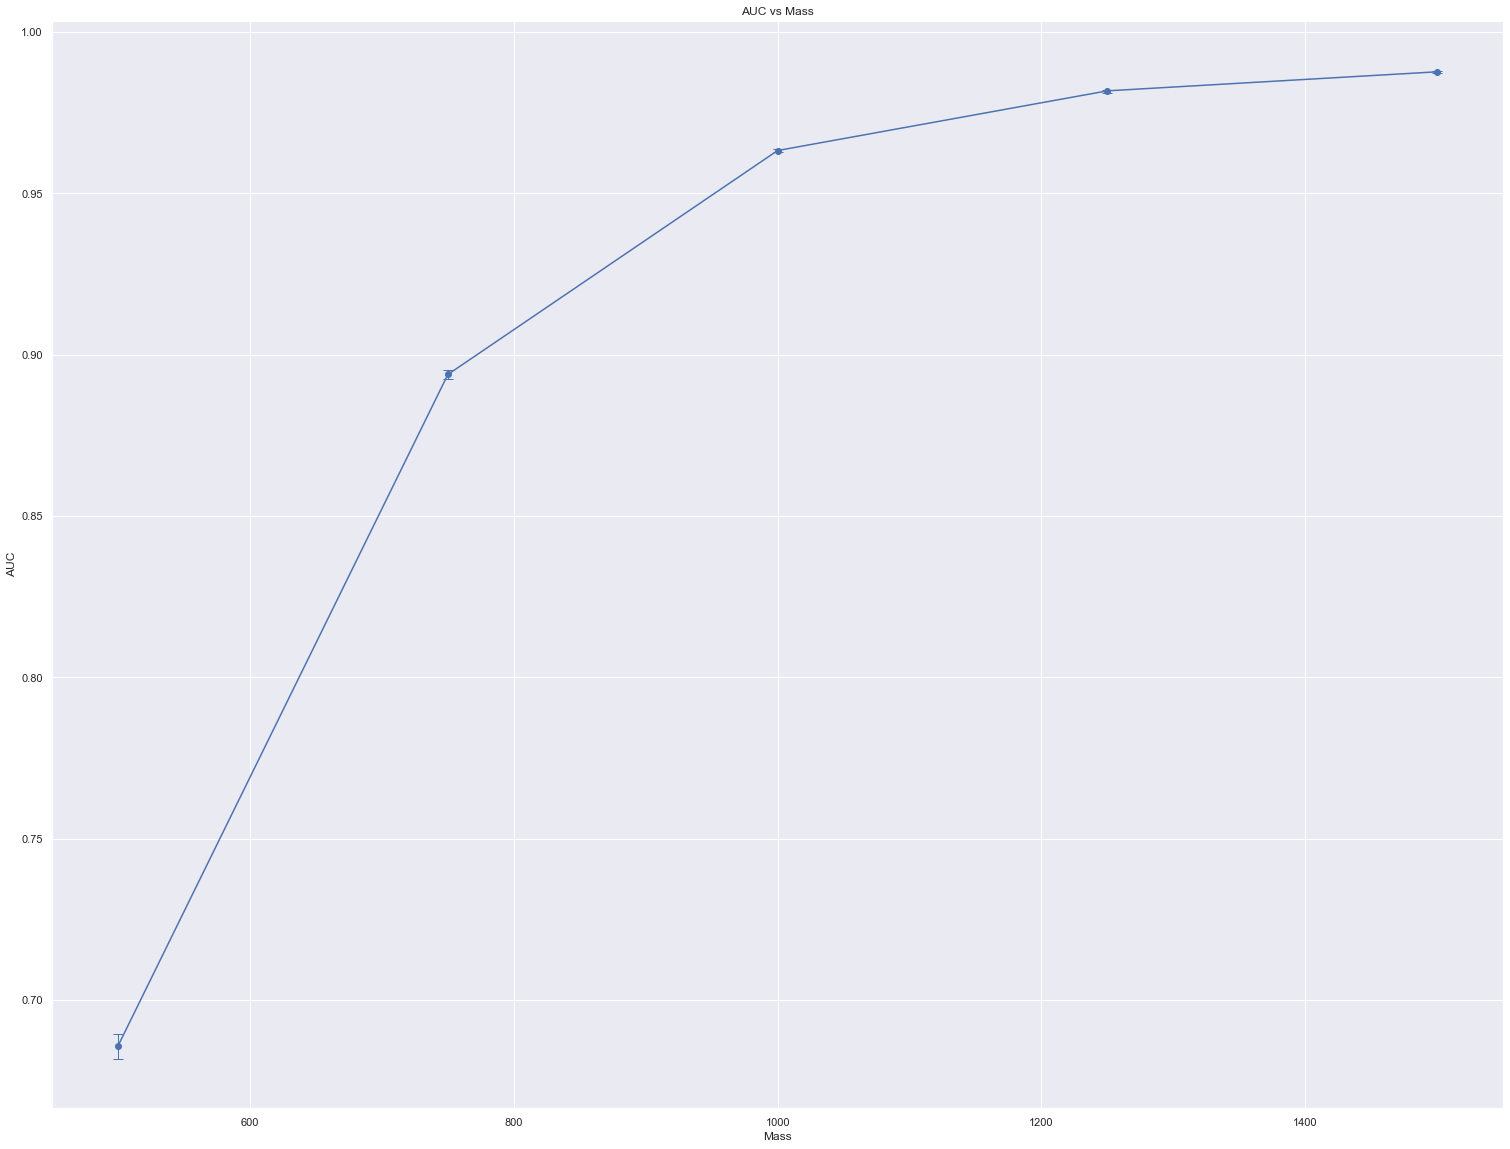

array([0.6859 , 0.89393, 0.96334, 0.9818 , 0.98773])

In [11]:
hepmass_eval.auc_with_error(nn, data, silent=True)

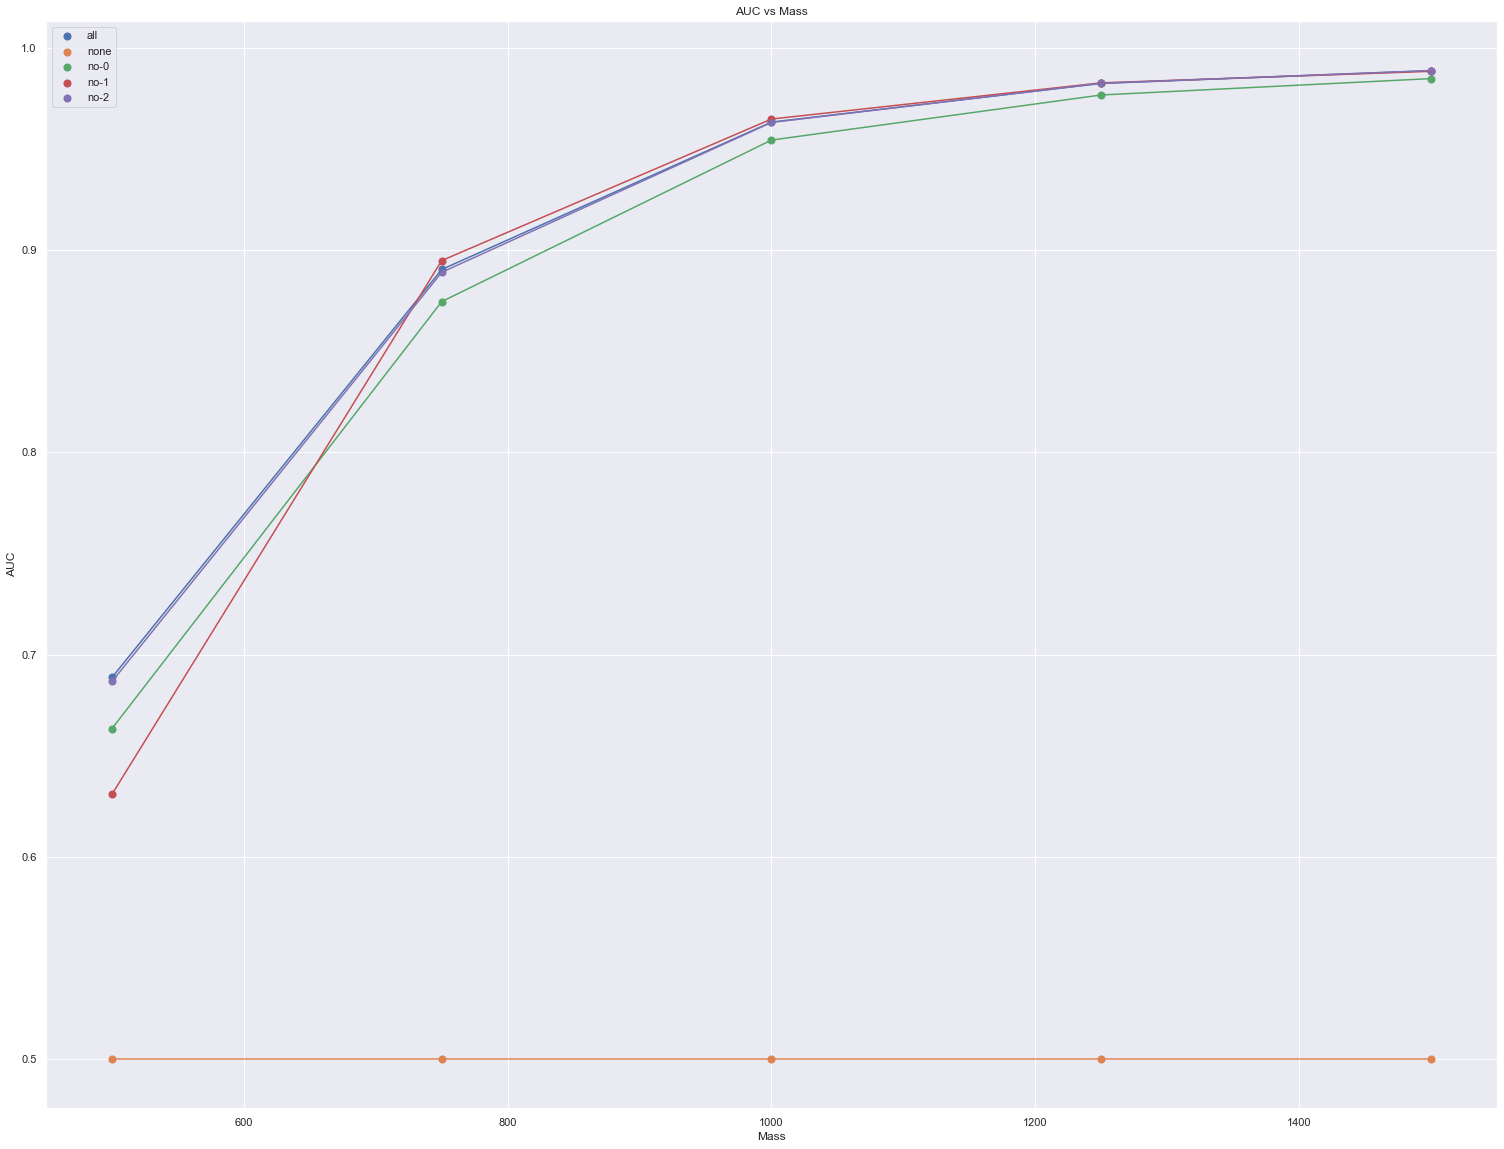

In [11]:
_ = hepmass_eval.auc_vs_mass_no_features(nn, data, features=hep_features[0], 
                                         auc_index=2, verbose=0, silent=True)

#### PNN

In [23]:
pnn, checkpoint = get_compiled_pnn(save='hepmass/baseline-pnn')
pnn.summary()

Model: "ParametricNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
m (InputLayer)                  [(None, 1)]          0                                            
__________________________________________________________________________________________________
x (InputLayer)                  [(None, 27)]         0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 28)           0           m[0][0]                          
                                                                 x[0][0]                          
__________________________________________________________________________________________________
dense_16 (Dense)                (None, 300)          8700        concatenate[0][0]     

In [24]:
_ = pnn.fit(x=x_train, y=y_train, batch_size=BATCH_SIZE, validation_split=VAL_SPLIT,
            epochs=NUM_EPOCHS, callbacks=[checkpoint])

# Accuracy: 88.21 (+6%), AUC: 95.68 (+5%)

Epoch 1/20
52500/52500 [==============================] - 180s 3ms/step - loss: 0.2801 - binary_accuracy: 0.8655 - auc: 0.9466 - precision_2: 0.8462 - recall_2: 0.8933 - lr: 0.0010 - grad-norm: 0.7167 - weight-norm: 34.0381 - reg-losses: 0.0000e+00 - val_loss: 0.2770 - val_binary_accuracy: 0.8737 - val_auc: 0.9518 - val_precision_2: 0.8497 - val_recall_2: 0.9081
Epoch 2/20
52500/52500 [==============================] - 176s 3ms/step - loss: 0.2825 - binary_accuracy: 0.8747 - auc: 0.9522 - precision_2: 0.8571 - recall_2: 0.8994 - lr: 0.0010 - grad-norm: 0.5817 - weight-norm: 49.0340 - reg-losses: 0.0000e+00 - val_loss: 0.2708 - val_binary_accuracy: 0.8768 - val_auc: 0.9537 - val_precision_2: 0.8651 - val_recall_2: 0.8929
Epoch 3/20
52500/52500 [==============================] - 179s 3ms/step - loss: 0.2526 - binary_accuracy: 0.8770 - auc: 0.9536 - precision_2: 0.8596 - recall_2: 0.9013 - lr: 0.0010 - grad-norm: 0.5389 - weight-norm: 59.8712 - reg-losses: 0.0000e+00 - val_loss: 0.2708 - 

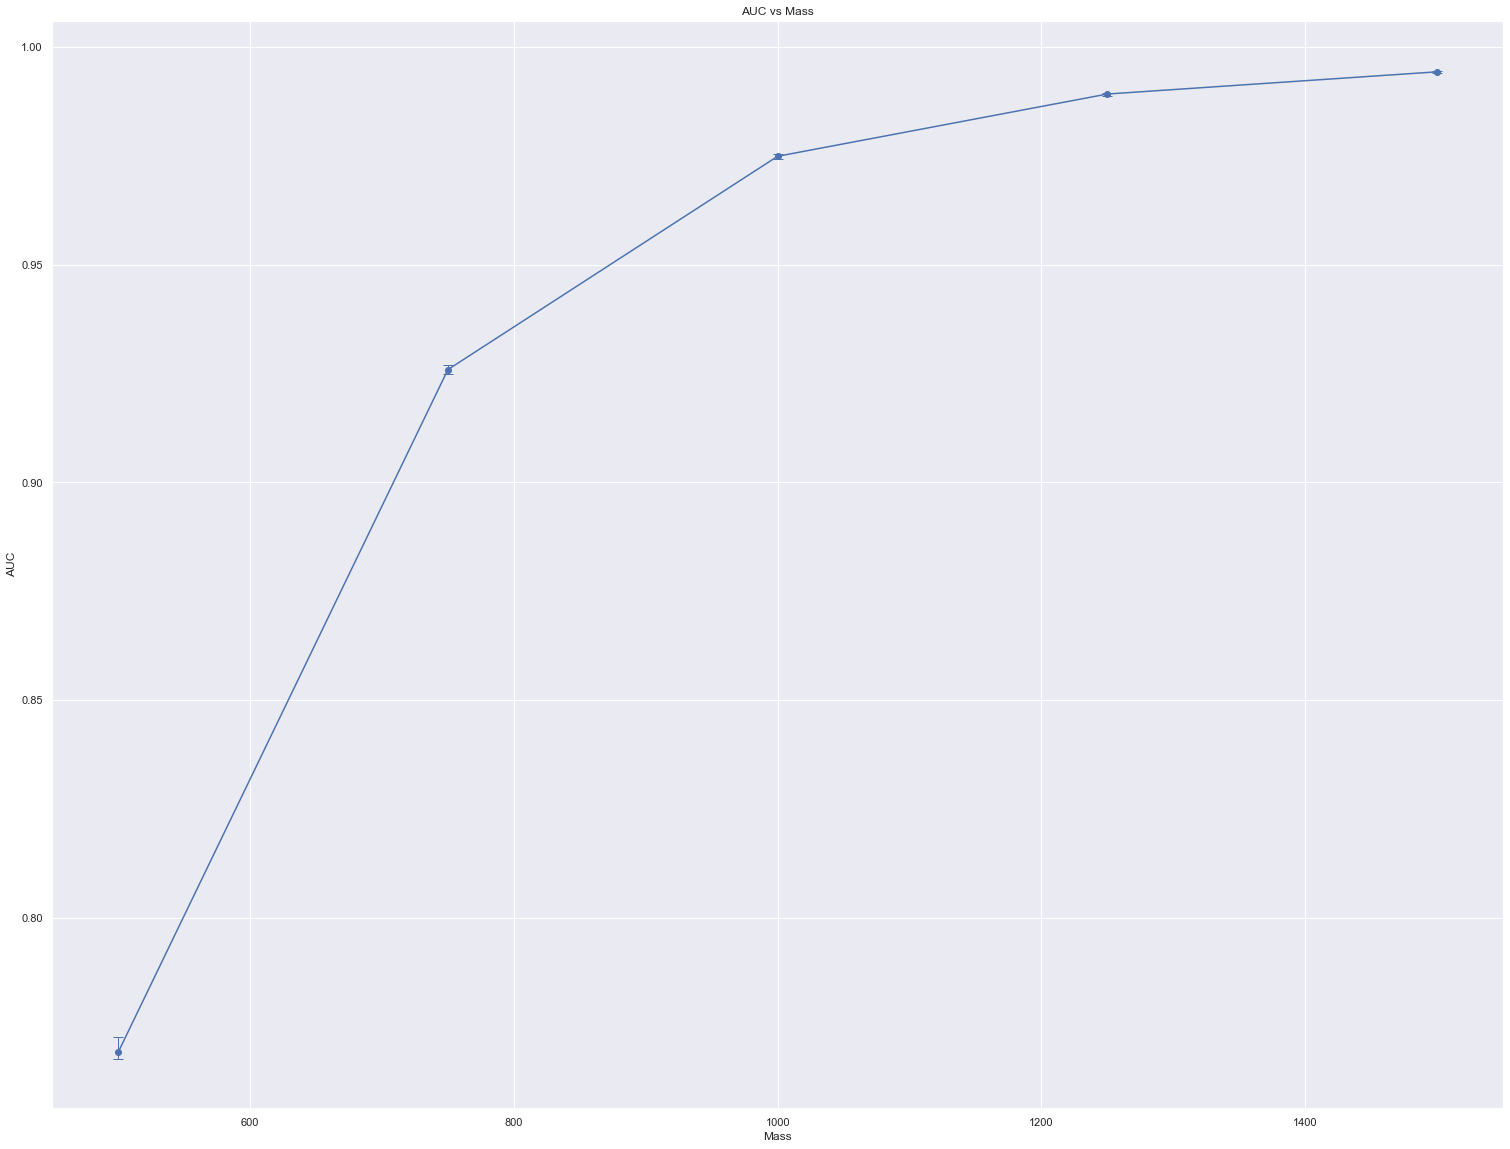

array([0.76905, 0.92589, 0.97487, 0.98917, 0.99432])

In [25]:
hepmass_eval.auc_with_error(pnn, data, silent=True)

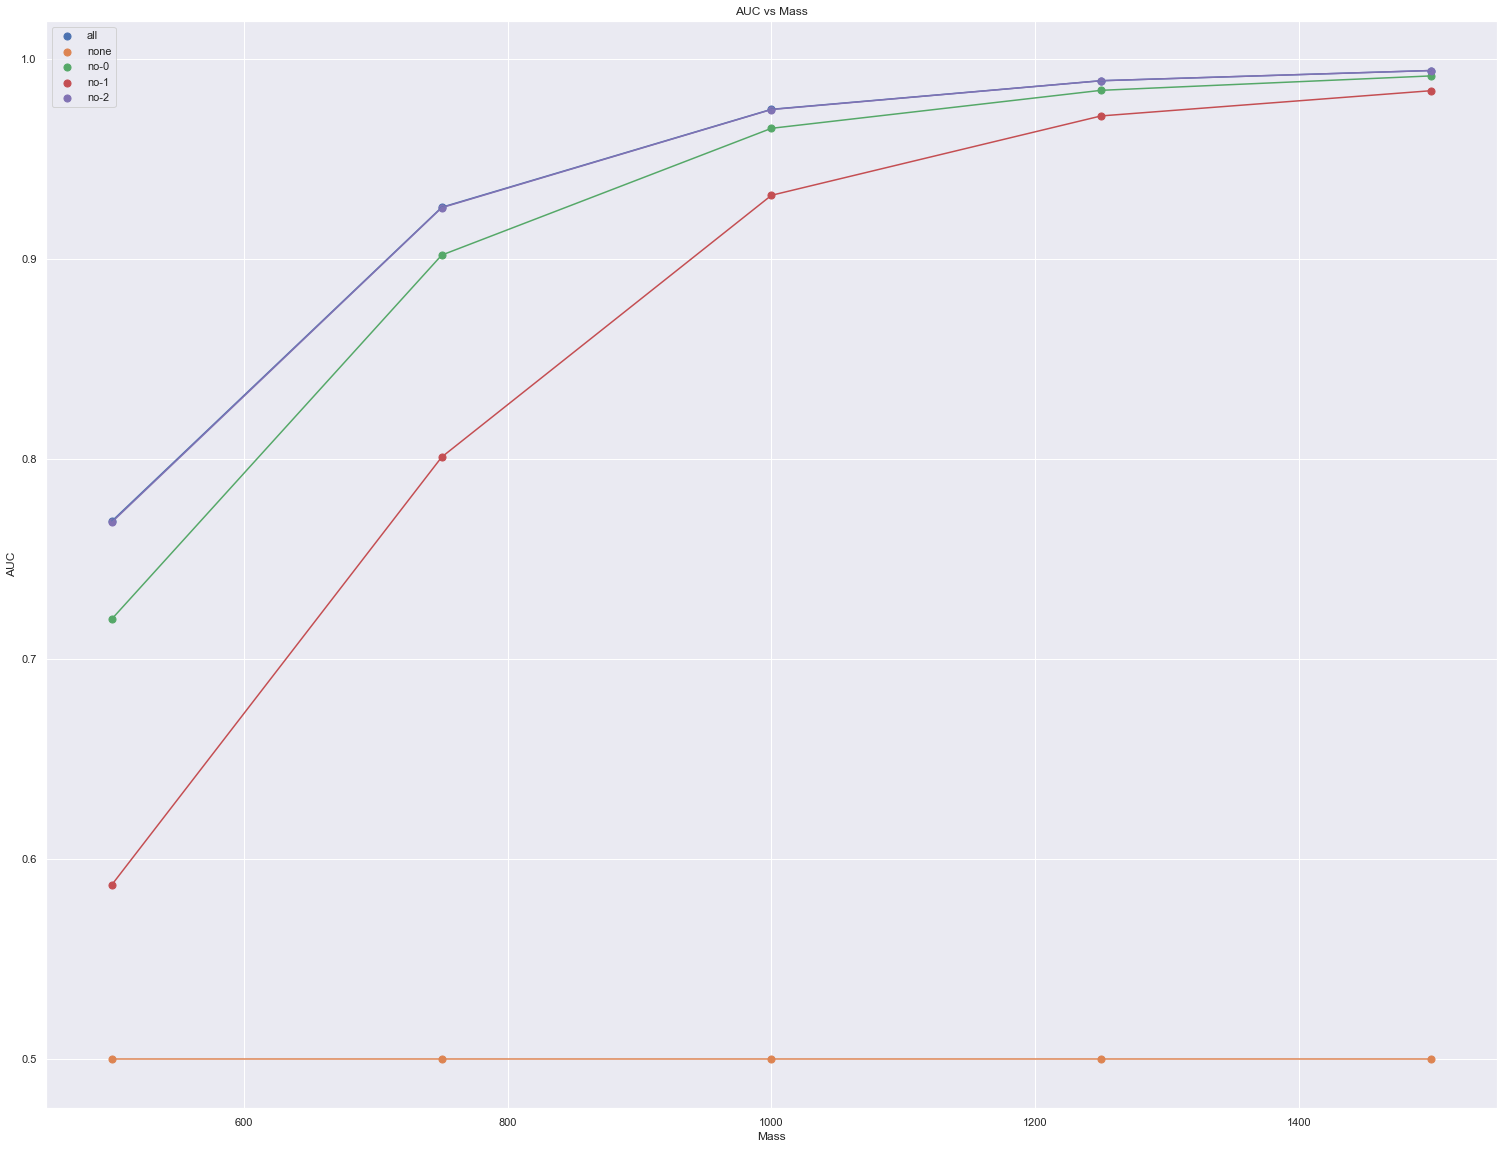

In [28]:
_ = hepmass_eval.auc_vs_mass_no_features(pnn, data, features=hep_features[0], 
                                         auc_index=2, verbose=0, silent=True)

#### AffinePNN

In [12]:
affine, checkpoint = get_compiled_affine_pnn(save='hepmass/baseline-affine', 
                                             track_mass_reliance=True)
affine.summary()

Model: "ParametricNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x (InputLayer)                  [(None, 27)]         0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 300)          8400        x[0][0]                          
__________________________________________________________________________________________________
m (InputLayer)                  [(None, 1)]          0                                            
__________________________________________________________________________________________________
affine-0 (AffineConditioning)   (None, 300)          1200        dense_4[0][0]                    
                                                                 m[0][0]               

In [13]:
_ = affine.fit(x=x_train, y=y_train, batch_size=BATCH_SIZE, validation_split=VAL_SPLIT,
               epochs=NUM_EPOCHS, callbacks=[checkpoint])

# Accuracy: 88.39 (+0.2%), AUC: 95.78 (+0.1%) 

Epoch 1/20
52500/52500 [==============================] - 277s 5ms/step - loss: 0.2504 - binary_accuracy: 0.8595 - auc: 0.9433 - precision_1: 0.8391 - recall_1: 0.8897 - cls-loss: 0.2986 - lr: 0.0010 - grad-norm: 0.5752 - weight-norm: 42.1305 - reg-losses: 0.0000e+00 - adversarial-loss: 0.0000e+00 - mass-reliance: 0.0667 - val_loss: 0.2811 - val_binary_accuracy: 0.8713 - val_auc: 0.9502 - val_precision_1: 0.8498 - val_recall_1: 0.9021
Epoch 2/20
52500/52500 [==============================] - 278s 5ms/step - loss: 0.3054 - binary_accuracy: 0.8730 - auc: 0.9511 - precision_1: 0.8551 - recall_1: 0.8983 - cls-loss: 0.2782 - lr: 0.0010 - grad-norm: 0.5249 - weight-norm: 59.6165 - reg-losses: 0.0000e+00 - adversarial-loss: 0.0000e+00 - mass-reliance: 0.0536 - val_loss: 0.2717 - val_binary_accuracy: 0.8766 - val_auc: 0.9534 - val_precision_1: 0.8556 - val_recall_1: 0.9062
Epoch 3/20
52500/52500 [==============================] - 277s 5ms/step - loss: 0.2647 - binary_accuracy: 0.8767 - auc: 0.

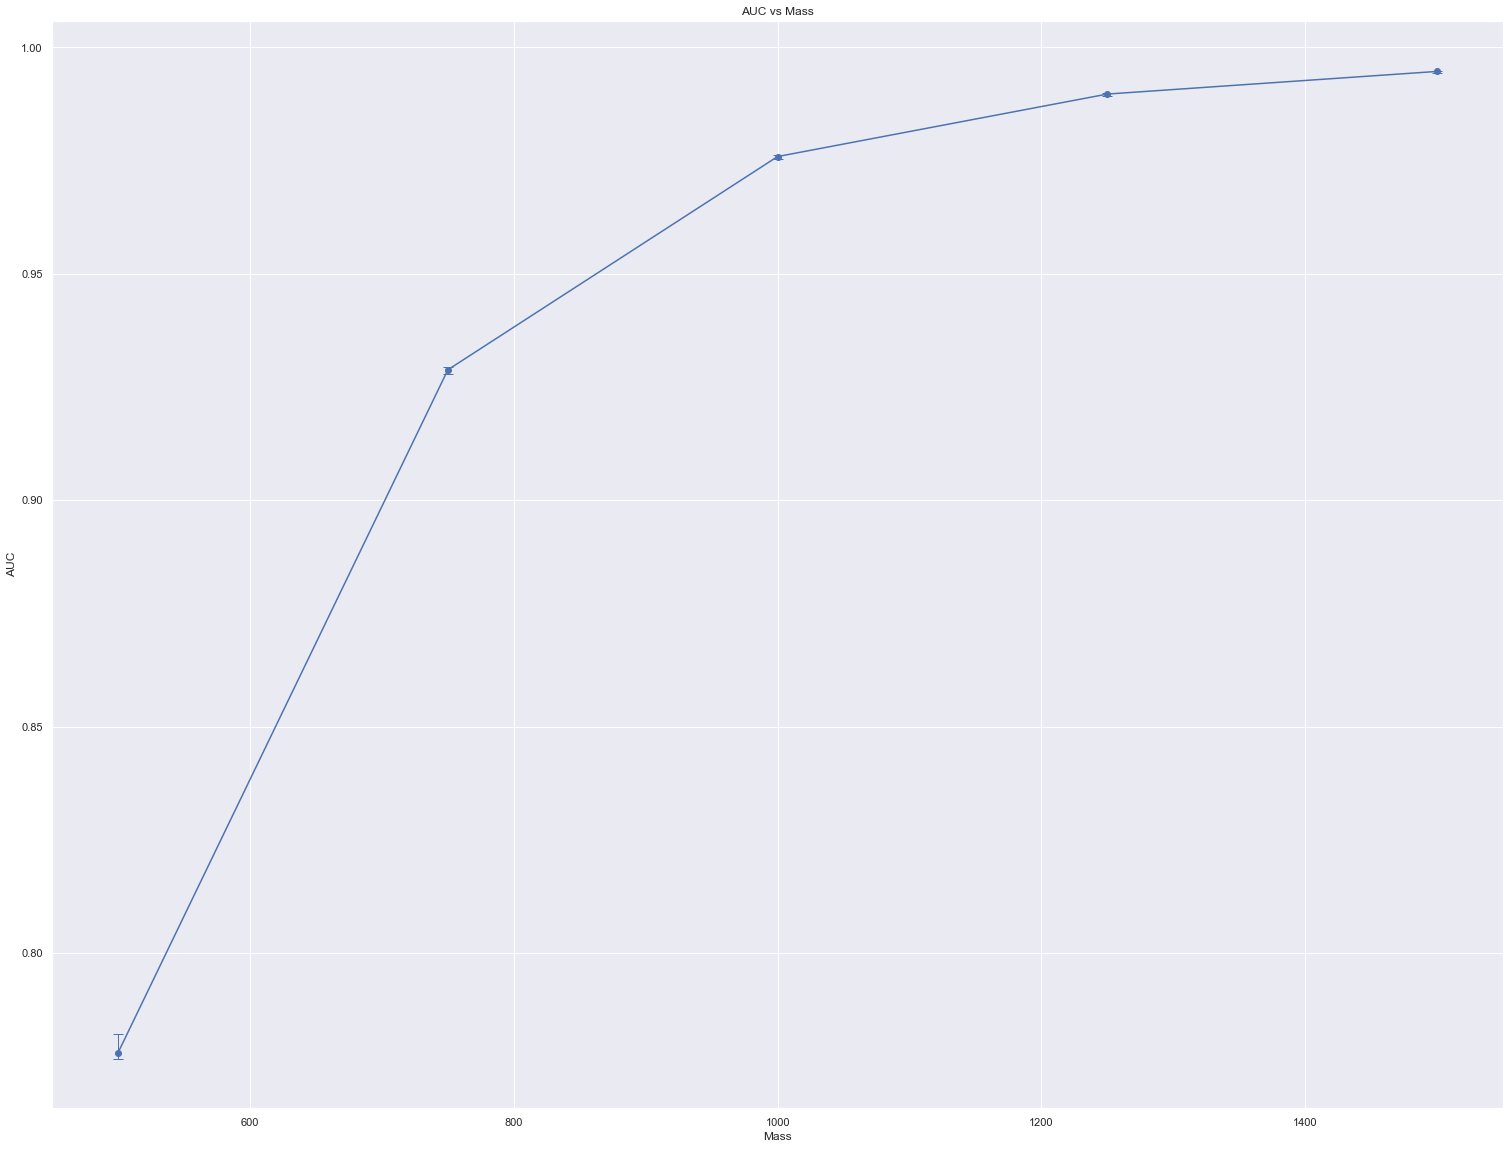

array([0.77799, 0.92878, 0.9759 , 0.98967, 0.99466])

In [14]:
hepmass_eval.auc_with_error(affine, data, silent=True)

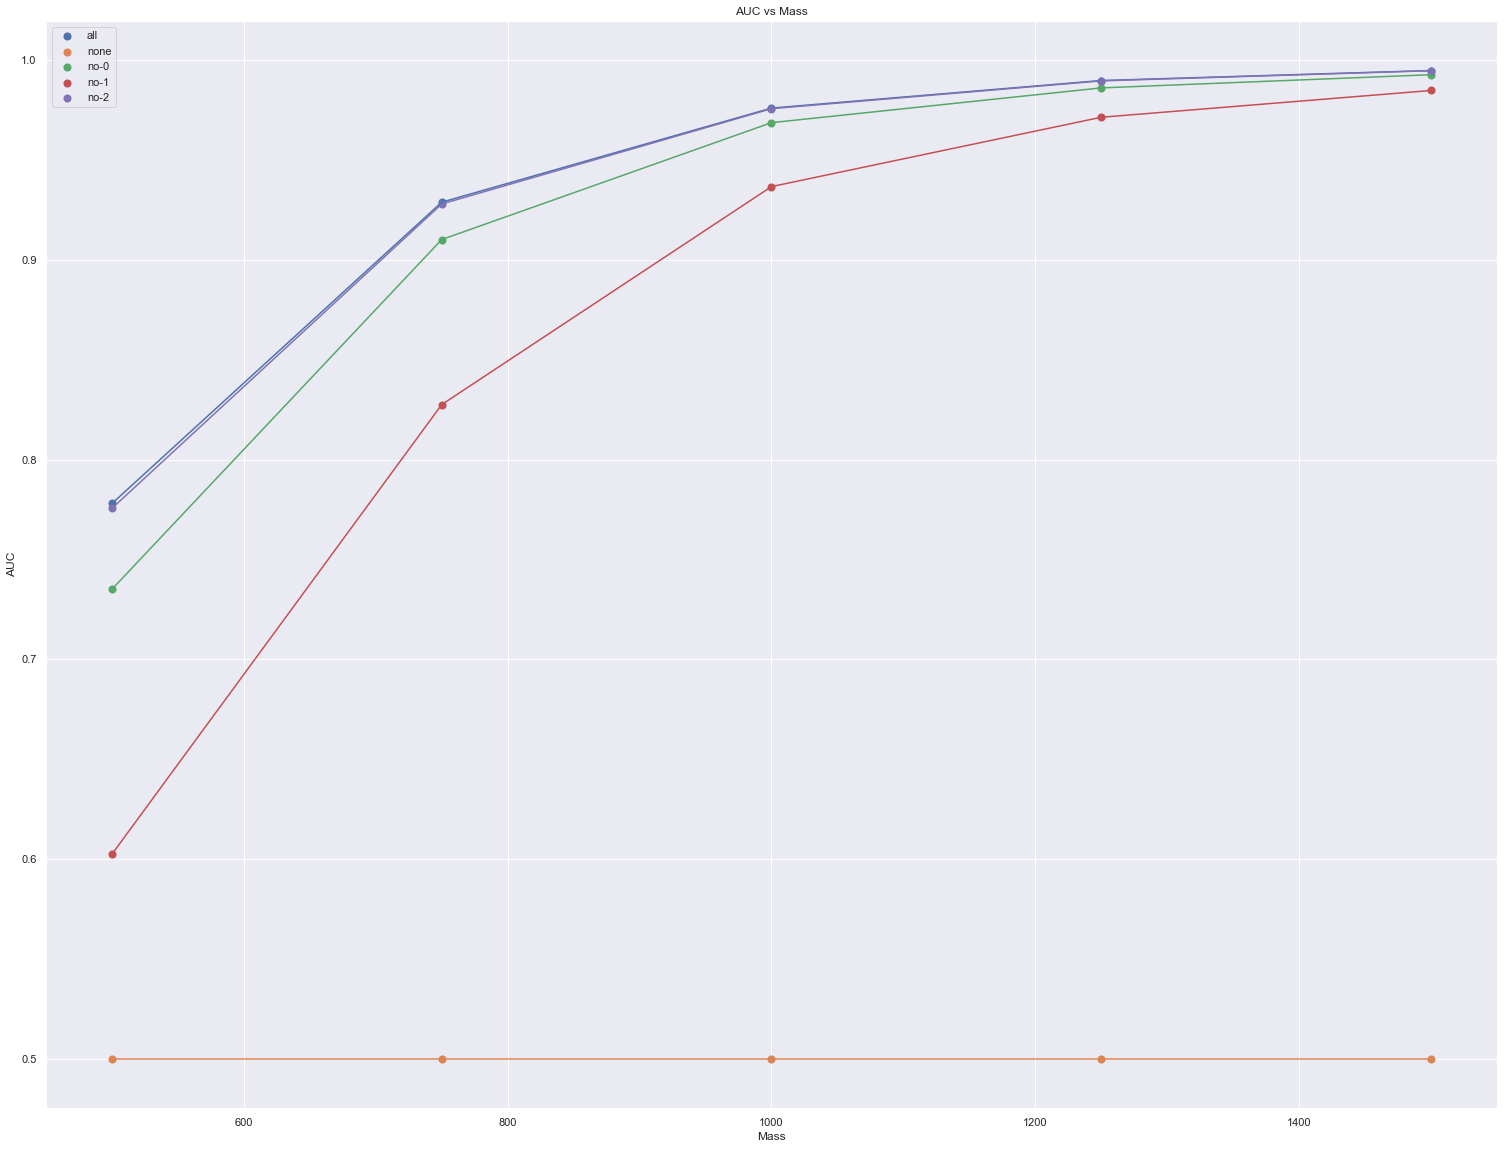

In [15]:
_ = hepmass_eval.auc_vs_mass_no_features(affine, data, features=hep_features[0], 
                                         auc_index=2, verbose=0, silent=True)

* The **feature reliance** of both pNN and AffinePNN is very similar: telling that they learned to exploit features in the same way?

---
AUC comparison:

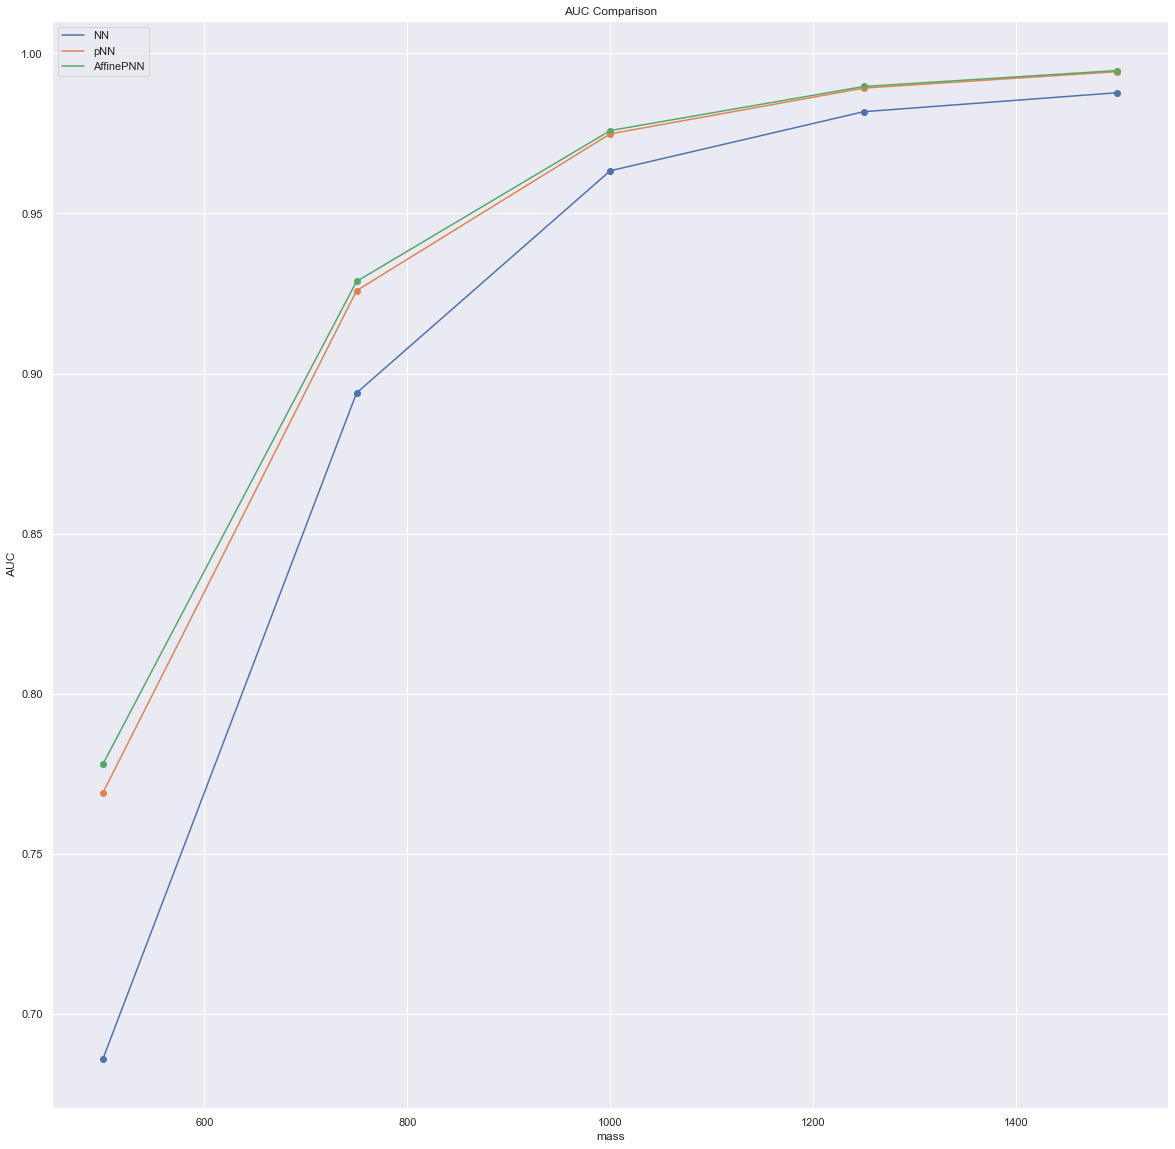

In [19]:
compare_plot(mass=[500, 750, 1000, 1250, 1500],
             NN=[0.6859 , 0.89393, 0.96334, 0.9818 , 0.98773],
             pNN=[0.76905, 0.92589, 0.97487, 0.98917, 0.99432],
             AffinePNN=[0.77799, 0.92878, 0.9759 , 0.98967, 0.99466])

### Robust
Clipped outliers

In [14]:
data = Hepmass(x_scaler=MinMaxScaler(), m_scaler=MinMaxScaler())
data.load(path=Hepmass.TRAIN_PATH, robust=True)

free_mem()
x_train, y_train = data.get()

loading...
clipping outliers..
fitting feature scaler..
fitting mass scaler..
dataset loaded.


#### Non-parametric NN

In [15]:
nn, checkpoint = get_compiled_non_parametric(save='hepmass/baseline-nn-robust')

nn.fit(x=x_train, y=y_train, batch_size=128, validation_split=VAL_SPLIT, 
       epochs=NUM_EPOCHS, callbacks=[checkpoint])

# Accuracy: 88.52, AUC: 95.48

Epoch 1/20
41016/41016 [==============================] - 191s 5ms/step - loss: 0.2716 - binary_accuracy: 0.8494 - auc: 0.9220 - precision: 0.9112 - recall: 0.7743 - lr: 0.0010 - grad-norm: 1.4980 - weight-norm: 31.1993 - reg-losses: 0.0000e+00 - val_loss: 0.2908 - val_binary_accuracy: 0.8679 - val_auc: 0.9404 - val_precision: 0.9364 - val_recall: 0.7895
Epoch 2/20
41016/41016 [==============================] - 195s 5ms/step - loss: 0.2121 - binary_accuracy: 0.8608 - auc: 0.9321 - precision: 0.9251 - recall: 0.7853 - lr: 0.0010 - grad-norm: 2.0893 - weight-norm: 42.2417 - reg-losses: 0.0000e+00 - val_loss: 0.3267 - val_binary_accuracy: 0.8504 - val_auc: 0.9211 - val_precision: 0.9420 - val_recall: 0.7467
Epoch 3/20
41016/41016 [==============================] - 192s 5ms/step - loss: 0.2681 - binary_accuracy: 0.8642 - auc: 0.9350 - precision: 0.9283 - recall: 0.7894 - lr: 0.0010 - grad-norm: 2.1162 - weight-norm: 48.6224 - reg-losses: 0.0000e+00 - val_loss: 0.2706 - val_binary_accuracy:

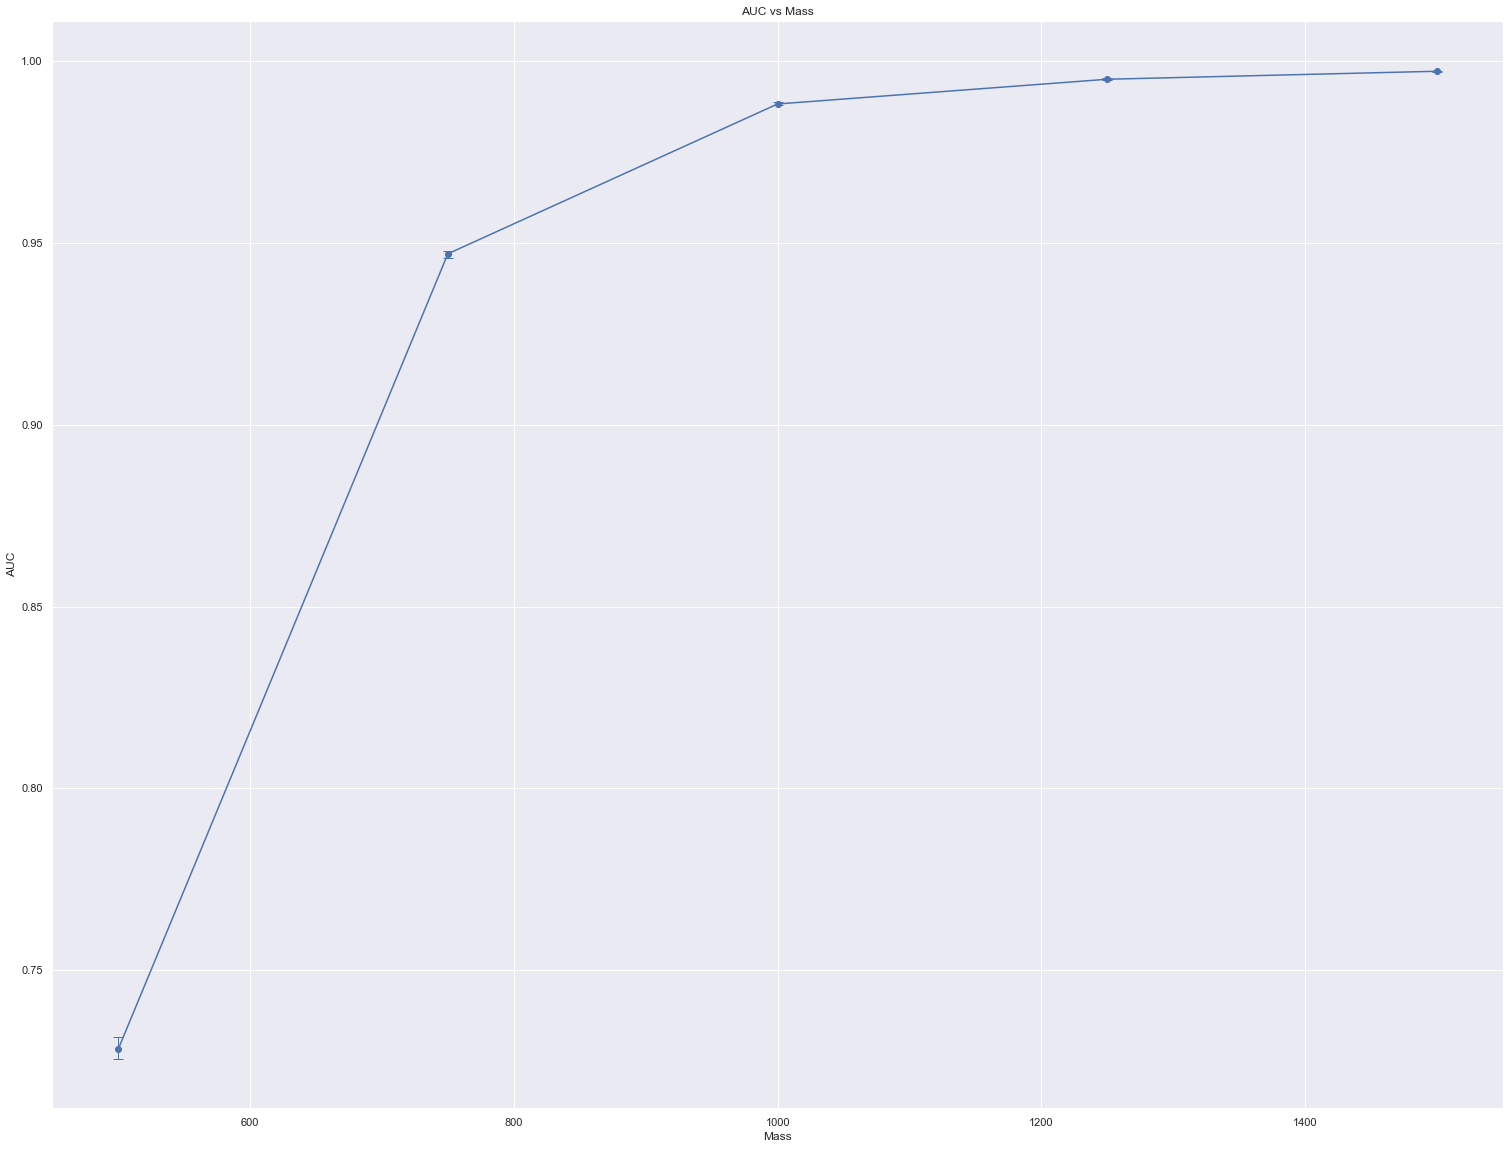

array([0.72817, 0.94704, 0.98821, 0.99502, 0.99717])

In [16]:
hepmass_eval.auc_with_error(nn, data, silent=True)

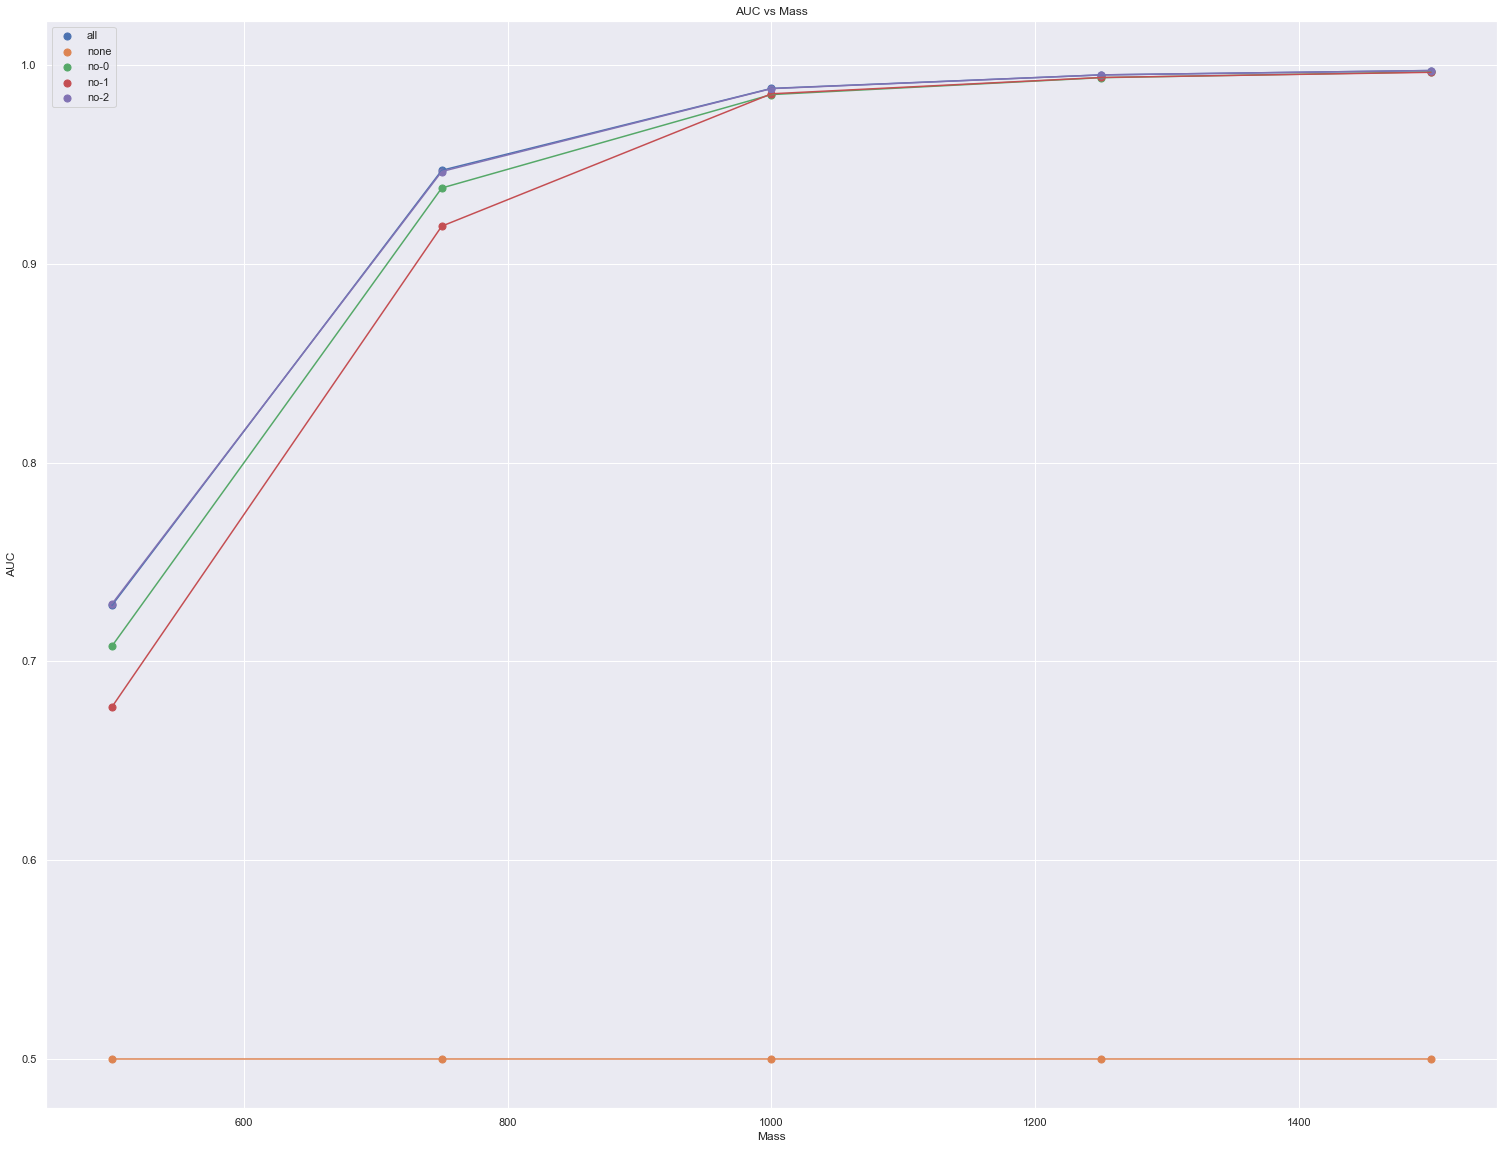

In [20]:
_ = hepmass_eval.auc_vs_mass_no_features(nn, data, features=hep_features[0], 
                                         auc_index=2, verbose=0, silent=True)

#### PNN

In [25]:
pnn, checkpoint = get_compiled_pnn(save='hepmass/baseline-pnn-robust')
pnn.summary()

Model: "ParametricNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
m (InputLayer)                  [(None, 1)]          0                                            
__________________________________________________________________________________________________
x (InputLayer)                  [(None, 27)]         0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 28)           0           m[0][0]                          
                                                                 x[0][0]                          
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 300)          8700        concatenate[0][0]     

In [9]:
h = pnn.fit(x=x_train, y=y_train, batch_size=128, validation_split=VAL_SPLIT, 
            epochs=NUM_EPOCHS, callbacks=[checkpoint])

# Accuracy: 92.79 (+4%), AUC: 98.51 (+3%)

Epoch 1/20
41016/41016 [==============================] - 178s 4ms/step - loss: 0.1725 - binary_accuracy: 0.8956 - auc: 0.9701 - precision: 0.8868 - recal: 0.9072 - lr: 0.0010 - grad-norm: 1.4130 - weight-norm: 34.0749 - reg-losses: 0.0000e+00 - val_loss: 0.1767 - val_binary_accuracy: 0.9159 - val_auc: 0.9800 - val_precision: 0.9063 - val_recal: 0.9278
Epoch 2/20
41016/41016 [==============================] - 189s 5ms/step - loss: 0.1114 - binary_accuracy: 0.9102 - auc: 0.9774 - precision: 0.9037 - recal: 0.9183 - lr: 0.0010 - grad-norm: 1.3324 - weight-norm: 48.9700 - reg-losses: 0.0000e+00 - val_loss: 0.1819 - val_binary_accuracy: 0.9117 - val_auc: 0.9785 - val_precision: 0.9115 - val_recal: 0.9119
Epoch 3/20
41016/41016 [==============================] - 183s 4ms/step - loss: 0.1557 - binary_accuracy: 0.9154 - auc: 0.9798 - precision: 0.9086 - recal: 0.9237 - lr: 0.0010 - grad-norm: 1.1916 - weight-norm: 59.9208 - reg-losses: 0.0000e+00 - val_loss: 0.1709 - val_binary_accuracy: 0.91

In [26]:
pnn.load_weights('weights/hepmass/baseline-pnn-robust/weights-20-0.985')

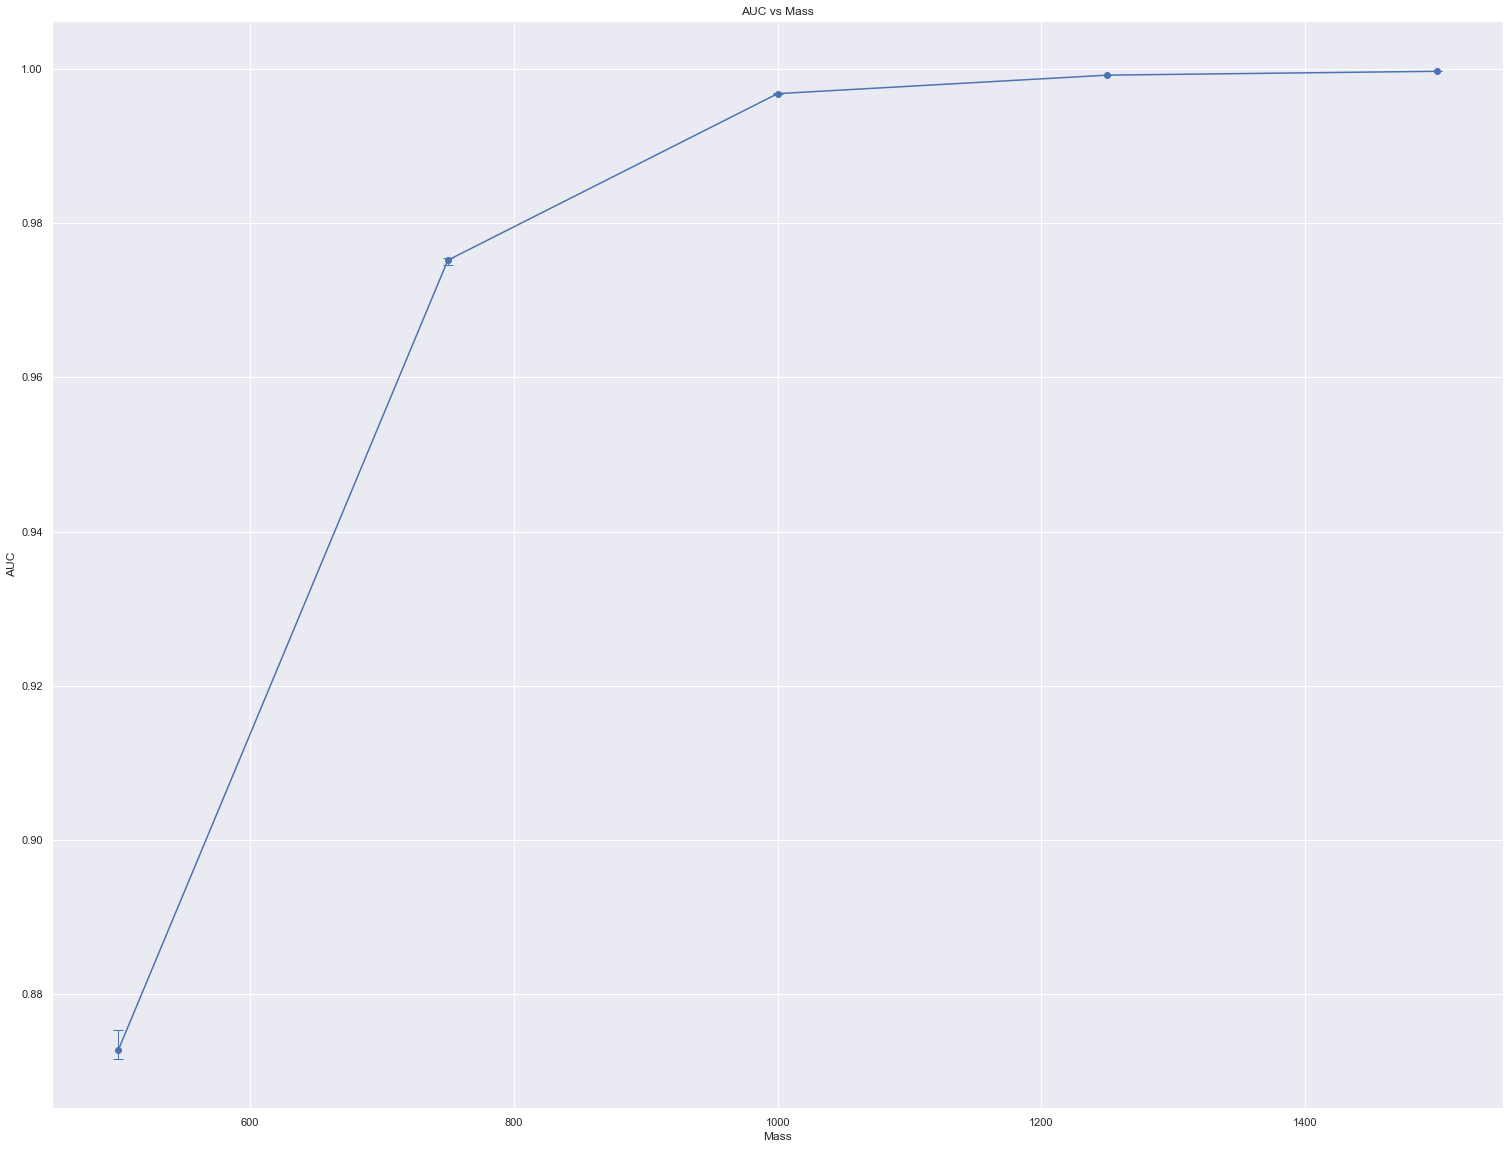

array([0.8727 , 0.97516, 0.99681, 0.9992 , 0.99972])

In [11]:
hepmass_eval.auc_with_error(pnn, data, silent=True)

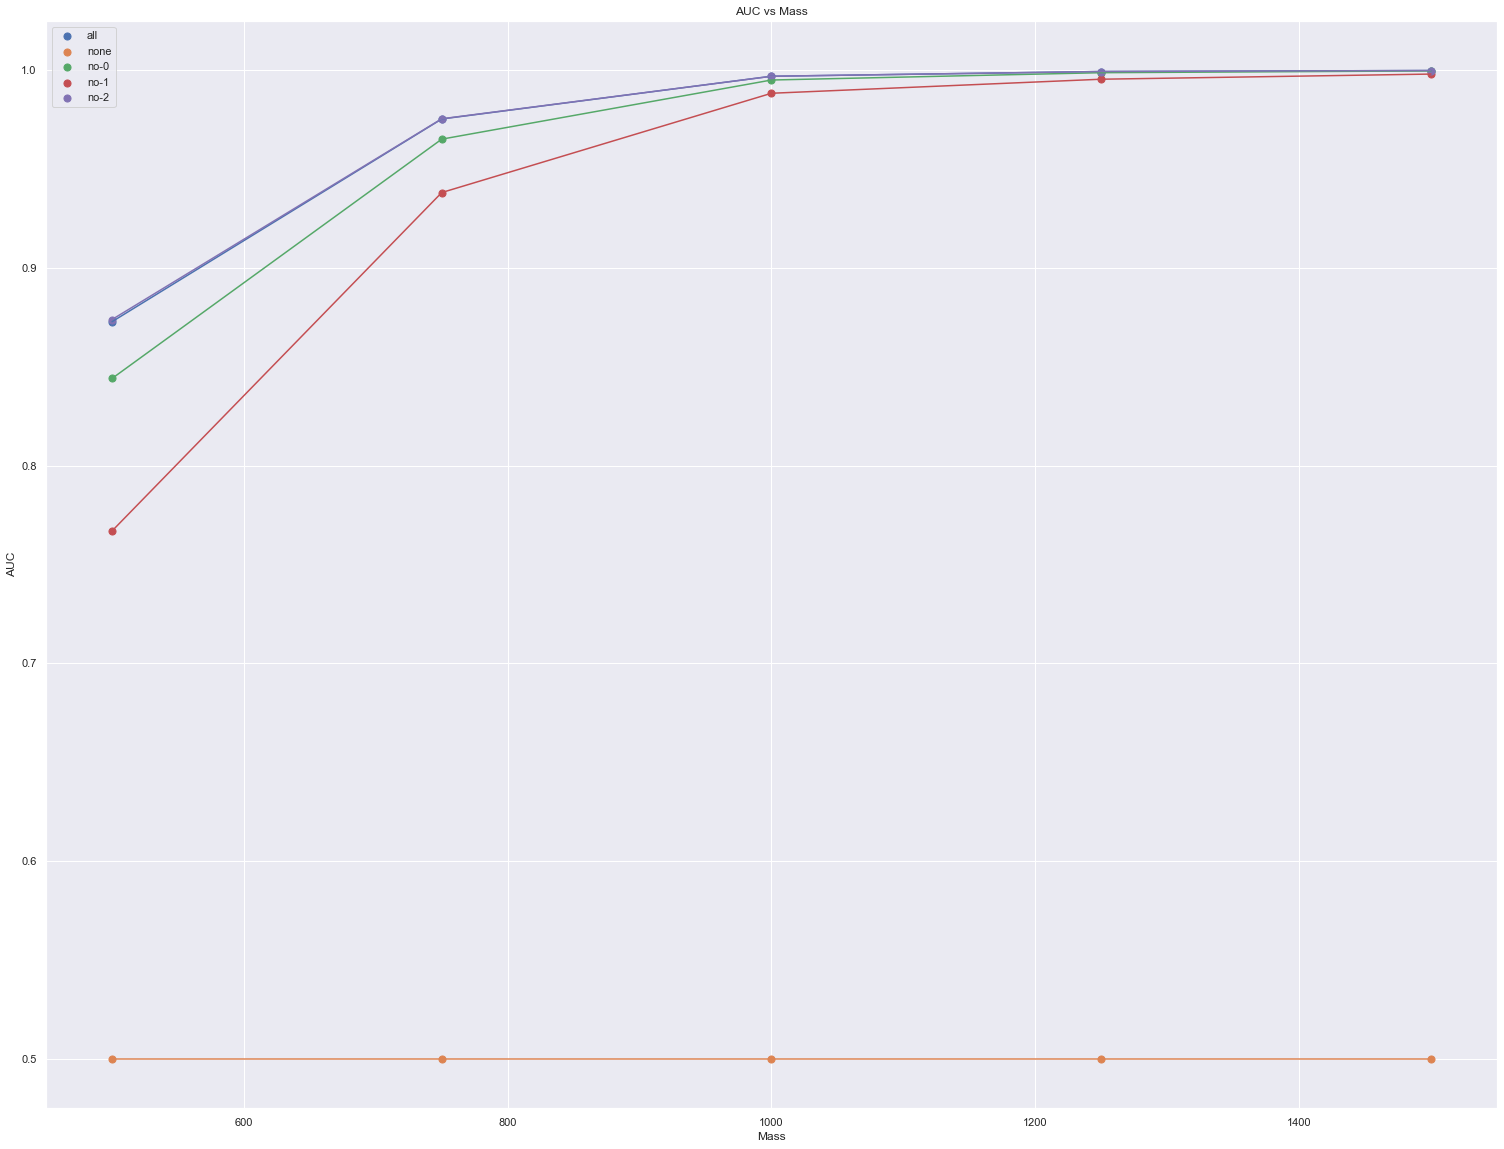

In [27]:
_ = hepmass_eval.auc_vs_mass_no_features(pnn, data, features=hep_features[0], 
                                         auc_index=2, verbose=0, silent=True)

#### AffinePNN

In [21]:
affine, checkpoint = get_compiled_affine_pnn(save='hepmass/baseline-affine-robust',
                                             track_mass_reliance=True)

affine.fit(x=x_train, y=y_train, batch_size=128, validation_split=VAL_SPLIT, 
           epochs=NUM_EPOCHS, callbacks=[checkpoint])

# Accuracy: 92.72, AUC: 98.63

Epoch 1/20
41016/41016 [==============================] - 203s 5ms/step - loss: 0.1379 - binary_accuracy: 0.8845 - auc: 0.9643 - precision_1: 0.8716 - recall_1: 0.9020 - cls-loss: 0.2340 - lr: 0.0010 - grad-norm: 1.5727 - weight-norm: 47.1910 - reg-losses: 0.0000e+00 - adversarial-loss: 0.0000e+00 - mass-reliance: 0.0589 - val_loss: 0.1880 - val_binary_accuracy: 0.9093 - val_auc: 0.9773 - val_precision_1: 0.9102 - val_recall_1: 0.9081
Epoch 2/20
41016/41016 [==============================] - 225s 5ms/step - loss: 0.1023 - binary_accuracy: 0.9084 - auc: 0.9769 - precision_1: 0.9028 - recall_1: 0.9155 - cls-loss: 0.1885 - lr: 0.0010 - grad-norm: 1.7129 - weight-norm: 67.6763 - reg-losses: 0.0000e+00 - adversarial-loss: 0.0000e+00 - mass-reliance: 0.0711 - val_loss: 0.1699 - val_binary_accuracy: 0.9182 - val_auc: 0.9815 - val_precision_1: 0.9220 - val_recall_1: 0.9138
Epoch 3/20
41016/41016 [==============================] - 229s 6ms/step - loss: 0.1391 - binary_accuracy: 0.9147 - auc: 0.

41016/41016 [==============================] - 227s 6ms/step - loss: 0.0672 - binary_accuracy: 0.9281 - auc: 0.9852 - precision_1: 0.9228 - recall_1: 0.9343 - cls-loss: 0.1517 - lr: 0.0010 - grad-norm: 0.8633 - weight-norm: 182.4792 - reg-losses: 0.0000e+00 - adversarial-loss: 0.0000e+00 - mass-reliance: 0.0359 - val_loss: 0.1468 - val_binary_accuracy: 0.9310 - val_auc: 0.9863 - val_precision_1: 0.9212 - val_recall_1: 0.9427
Epoch 20/20
41016/41016 [==============================] - 234s 6ms/step - loss: 0.1151 - binary_accuracy: 0.9286 - auc: 0.9854 - precision_1: 0.9234 - recall_1: 0.9348 - cls-loss: 0.1508 - lr: 0.0010 - grad-norm: 0.8853 - weight-norm: 188.1764 - reg-losses: 0.0000e+00 - adversarial-loss: 0.0000e+00 - mass-reliance: 0.0354 - val_loss: 0.1532 - val_binary_accuracy: 0.9272 - val_auc: 0.9849 - val_precision_1: 0.9179 - val_recall_1: 0.9383


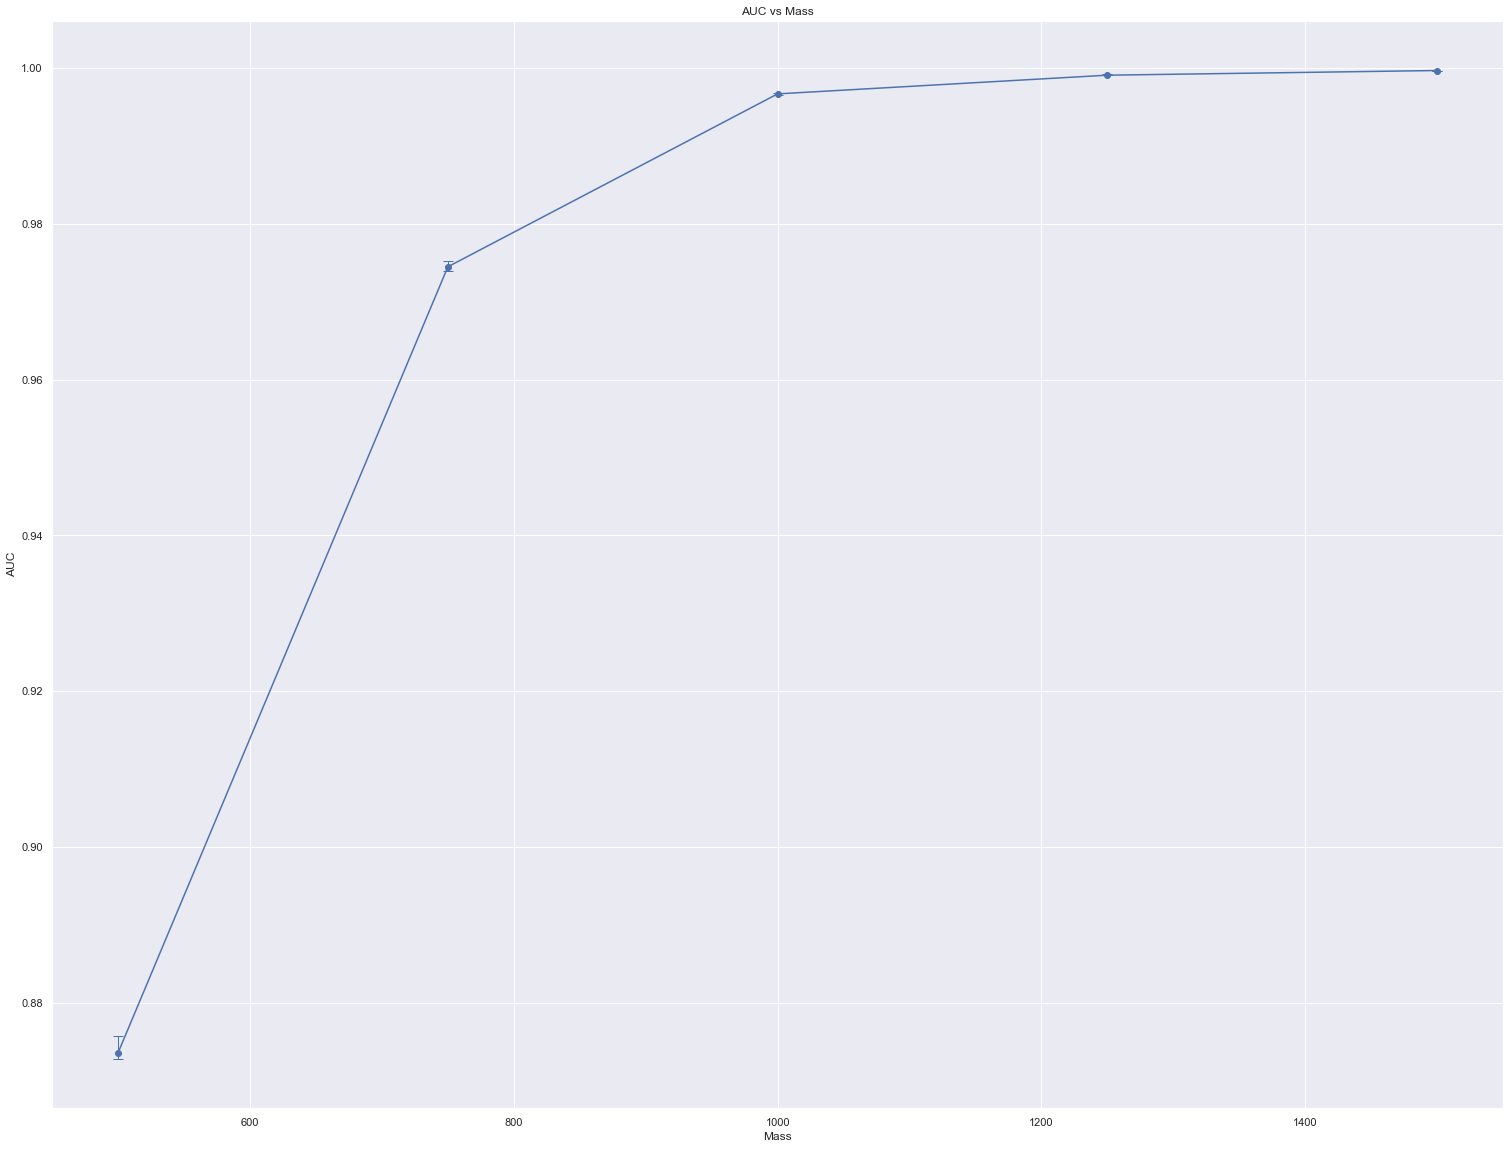

array([0.87359, 0.97454, 0.99672, 0.99914, 0.99967])

In [22]:
hepmass_eval.auc_with_error(affine, data, silent=True)

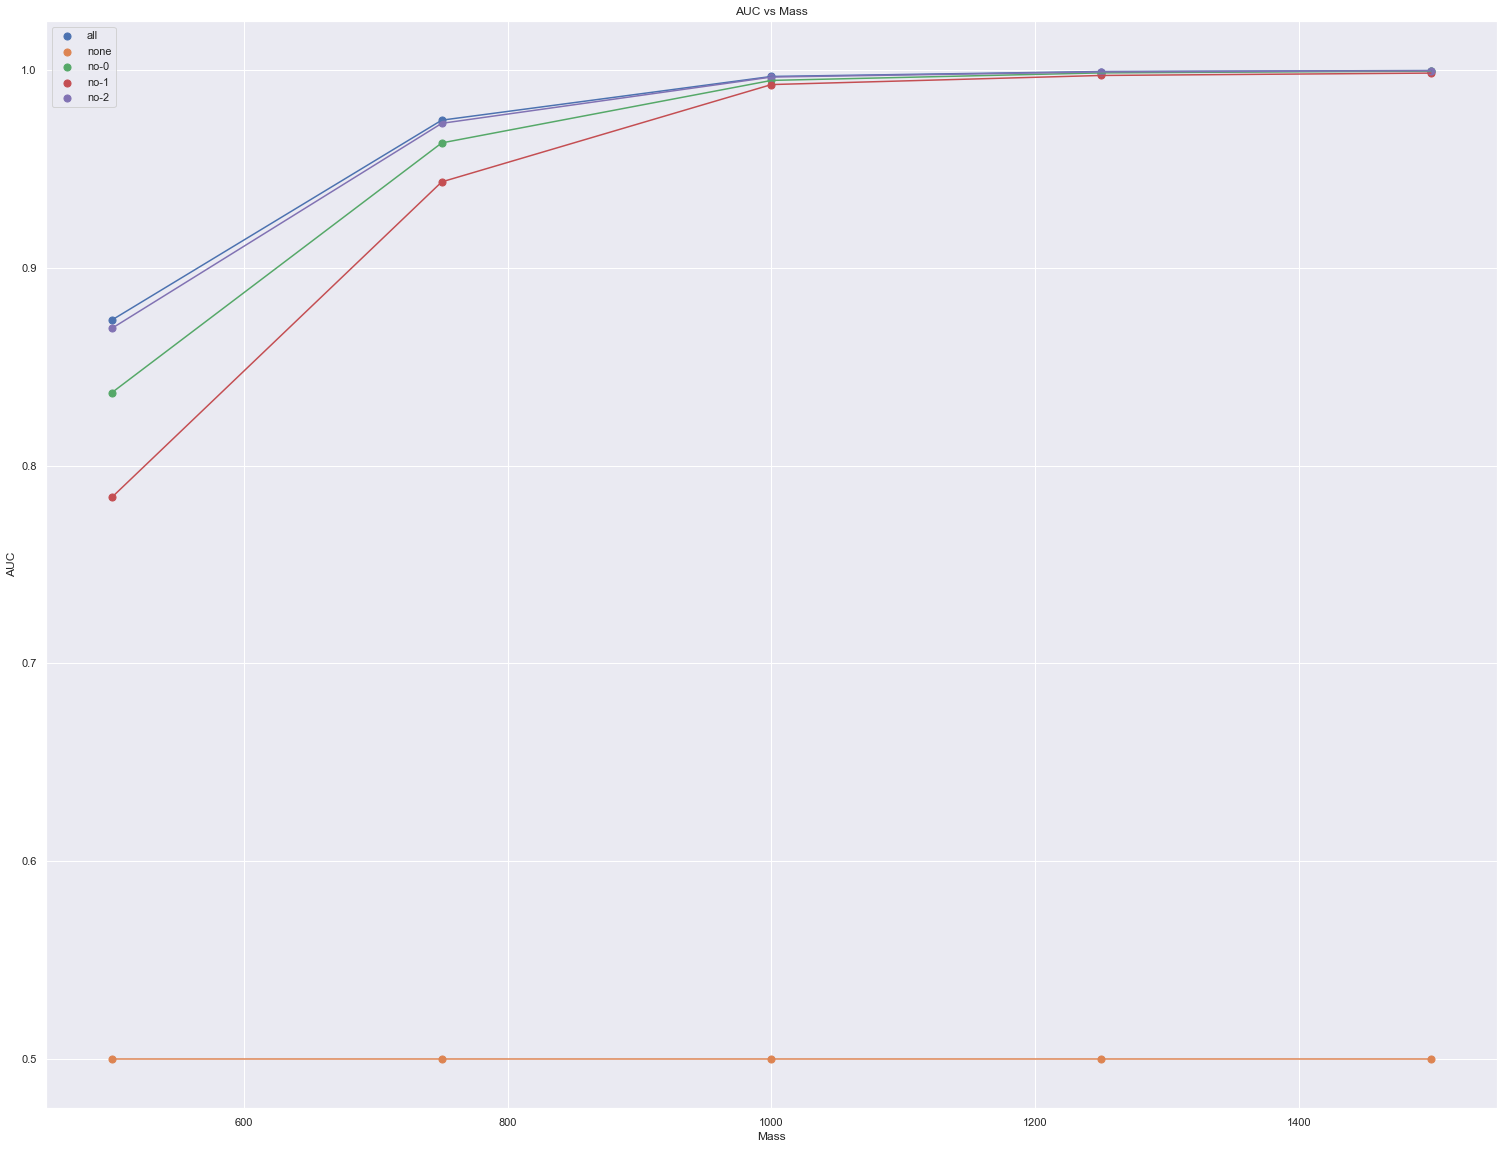

In [23]:
_ = hepmass_eval.auc_vs_mass_no_features(affine, data, features=hep_features[0], 
                                         auc_index=2, verbose=0, silent=True)

---
AUC comparison:

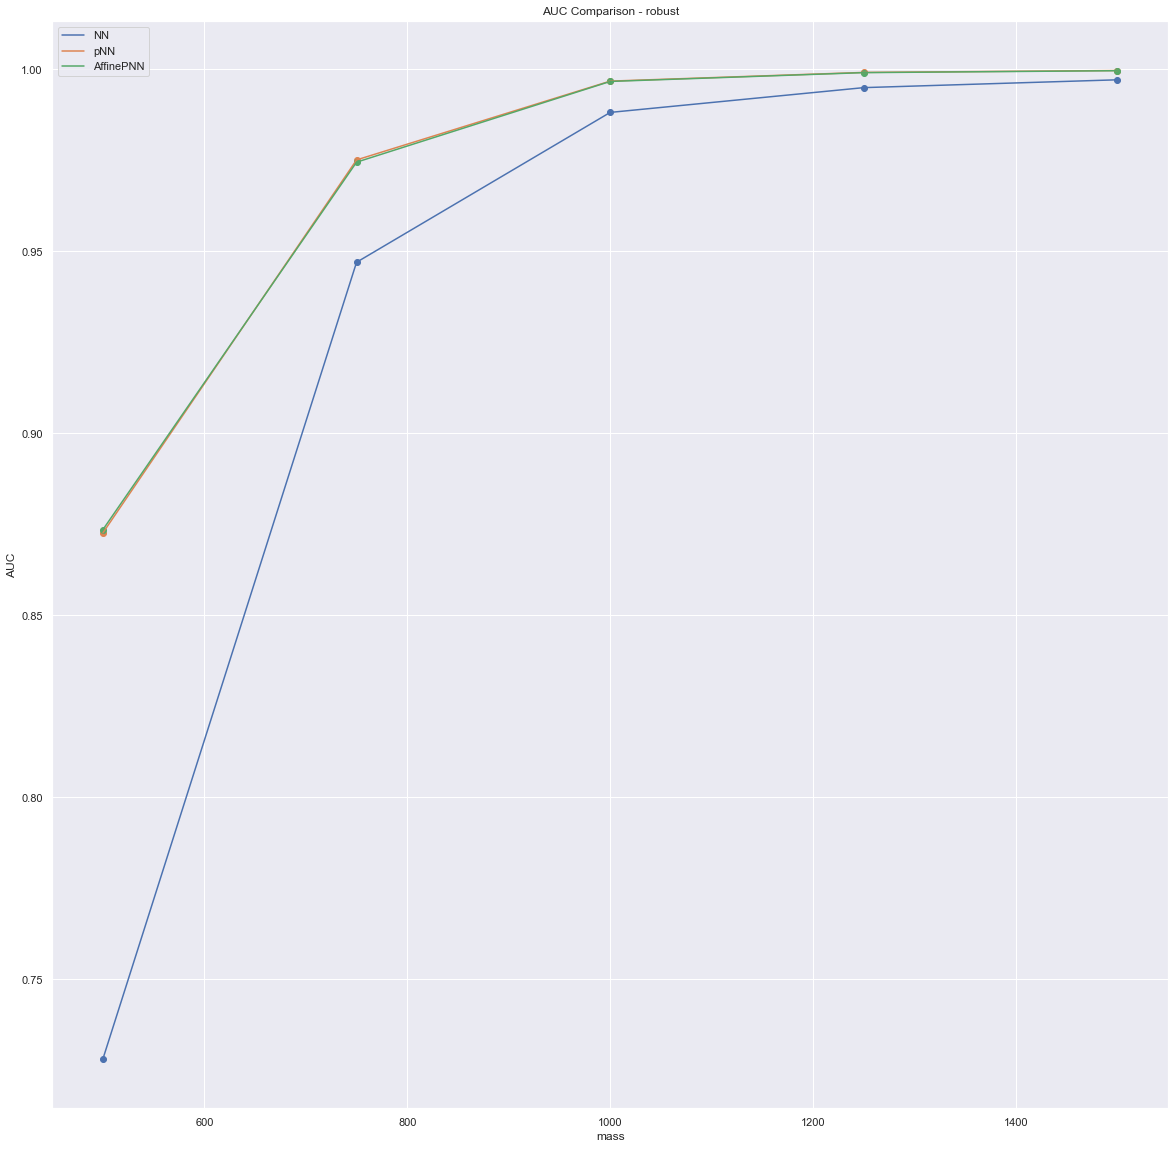

In [29]:
compare_plot(mass=[500, 750, 1000, 1250, 1500],
             title='AUC Comparison - robust',
             NN=[0.72817, 0.94704, 0.98821, 0.99502, 0.99717],
             pNN=[0.8727 , 0.97516, 0.99681, 0.9992 , 0.99972],
             AffinePNN=[0.87359, 0.97454, 0.99672, 0.99914, 0.99967])

### Dataset

In [8]:
data = Dataset(x_scaler=MinMaxScaler(), m_scaler=MinMaxScaler())
data.load()

free_mem()
x_train, y_train = data.get()

[signal] loading...
[background] loading...
[Dataset] fitting feature scaler..
[Dataset] fitting mass scaler..
[Dataset] loaded.


In [ ]:
num_features = len(data.columns['feature'])
features = []

j = -1
for i in range(num_features):
    # add an entry telling to drop only the i-th feature column
    if i % 3 == 0:
        features.append({'all': [], 'none': np.arange(0, num_features)})
        j += 1

    features[j][f'no-{i}'] = [i]

#### Non-parametric NN

In [10]:
nn, checkpoint = get_compiled_non_parametric(save='tom/baseline-nn')
nn.summary()

Model: "NonParam-NN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x (InputLayer)                  [(None, 13)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 300)          4200        x[0][0]                          
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 150)          45150       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 100)          15100       dense_1[0][0]                    
________________________________________________________________________________________

In [11]:
_ = nn.fit(x=x_train, y=y_train, batch_size=BATCH_SIZE, validation_split=VAL_SPLIT,
           epochs=NUM_EPOCHS, callbacks=[checkpoint])

# accuracy: 83.60, AUC: 91.65

Epoch 1/10
27405/27405 [==============================] - 110s 4ms/step - loss: 0.4682 - binary_accuracy: 0.8346 - auc: 0.9147 - precision: 0.7886 - recall: 0.8474 - lr: 0.0010 - grad-norm: 0.7098 - weight-norm: 161.4235 - reg-losses: 0.0000e+00 - val_loss: 0.3609 - val_binary_accuracy: 0.8346 - val_auc: 0.9158 - val_precision: 0.7990 - val_recall: 0.8277
Epoch 2/10
27405/27405 [==============================] - 112s 4ms/step - loss: 0.2991 - binary_accuracy: 0.8346 - auc: 0.9148 - precision: 0.7886 - recall: 0.8477 - lr: 0.0010 - grad-norm: 0.6937 - weight-norm: 169.8440 - reg-losses: 0.0000e+00 - val_loss: 0.3610 - val_binary_accuracy: 0.8346 - val_auc: 0.9155 - val_precision: 0.7950 - val_recall: 0.8347
Epoch 3/10
27405/27405 [==============================] - 112s 4ms/step - loss: 0.2882 - binary_accuracy: 0.8348 - auc: 0.9149 - precision: 0.7893 - recall: 0.8469 - lr: 0.0010 - grad-norm: 0.6806 - weight-norm: 177.6617 - reg-losses: 0.0000e+00 - val_loss: 0.3610 - val_binary_accura

In [11]:
nn.load_weights('weights/tom/baseline-nn/weights-10-0.917')

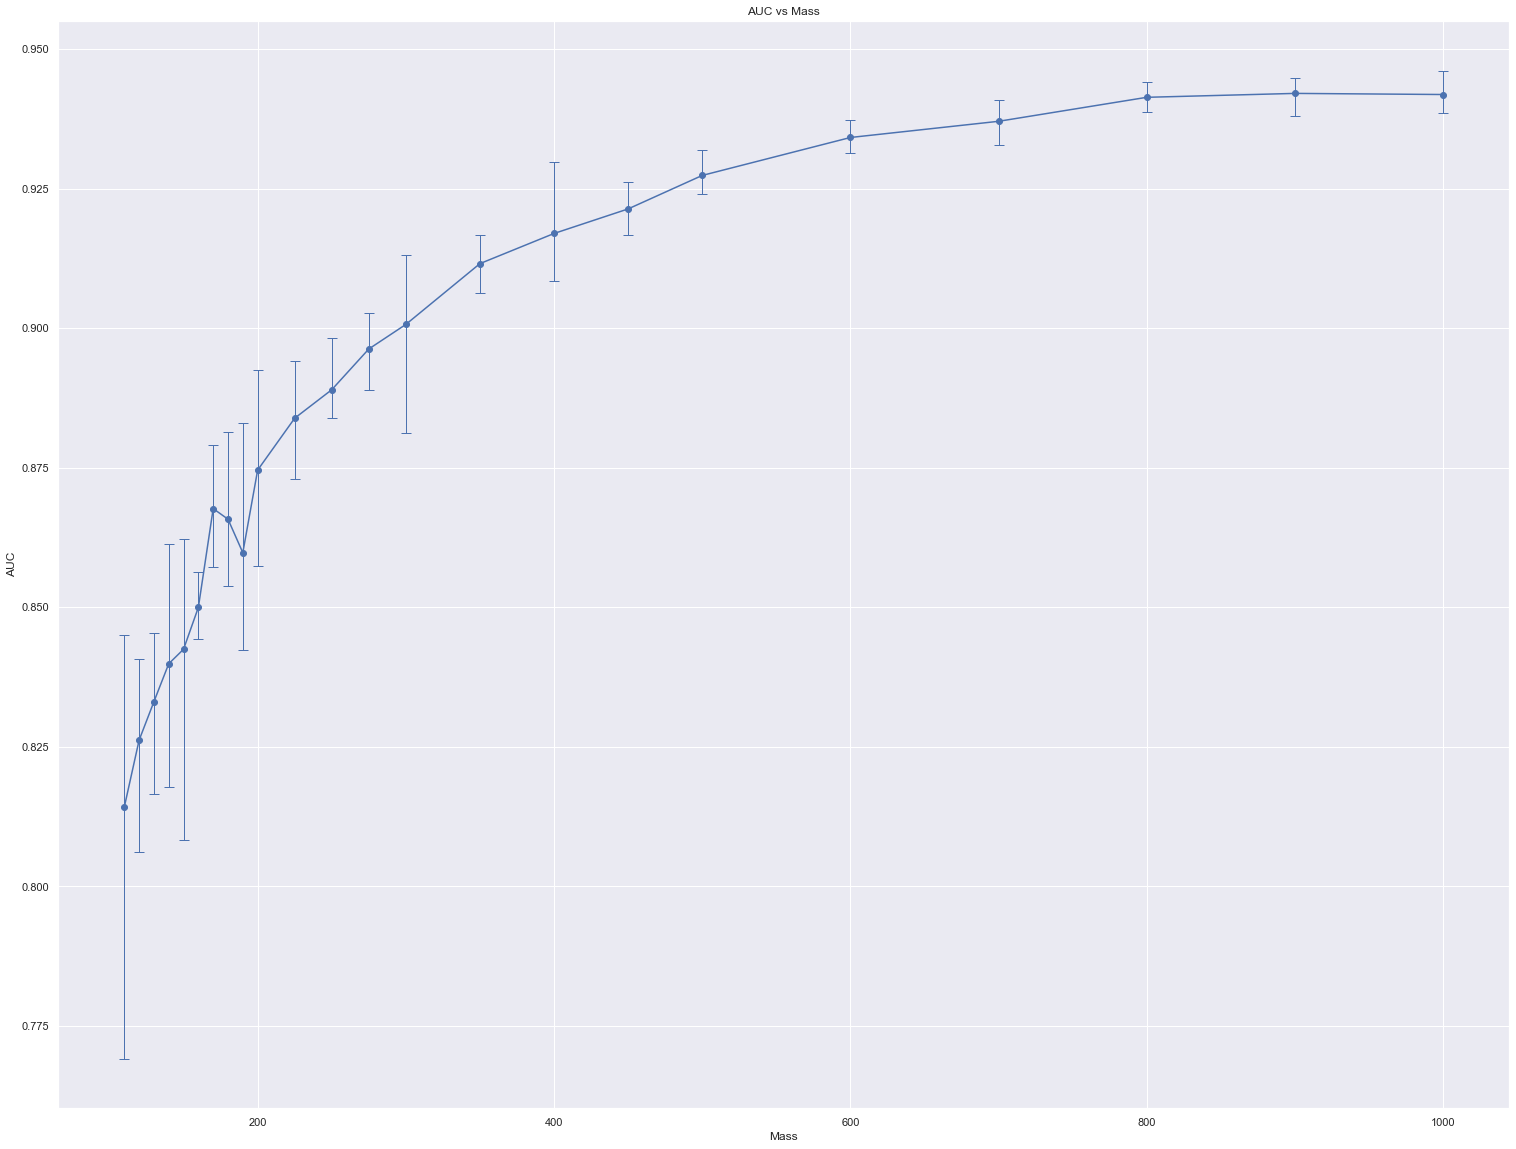

array([0.81417, 0.82621, 0.83311, 0.83991, 0.84247, 0.85001, 0.86768,
       0.86581, 0.85978, 0.87462, 0.88391, 0.88903, 0.89631, 0.90069,
       0.91159, 0.91702, 0.92142, 0.92735, 0.93422, 0.93713, 0.94143,
       0.94207, 0.94187])

In [12]:
auc_with_error(nn, data, silent=True)

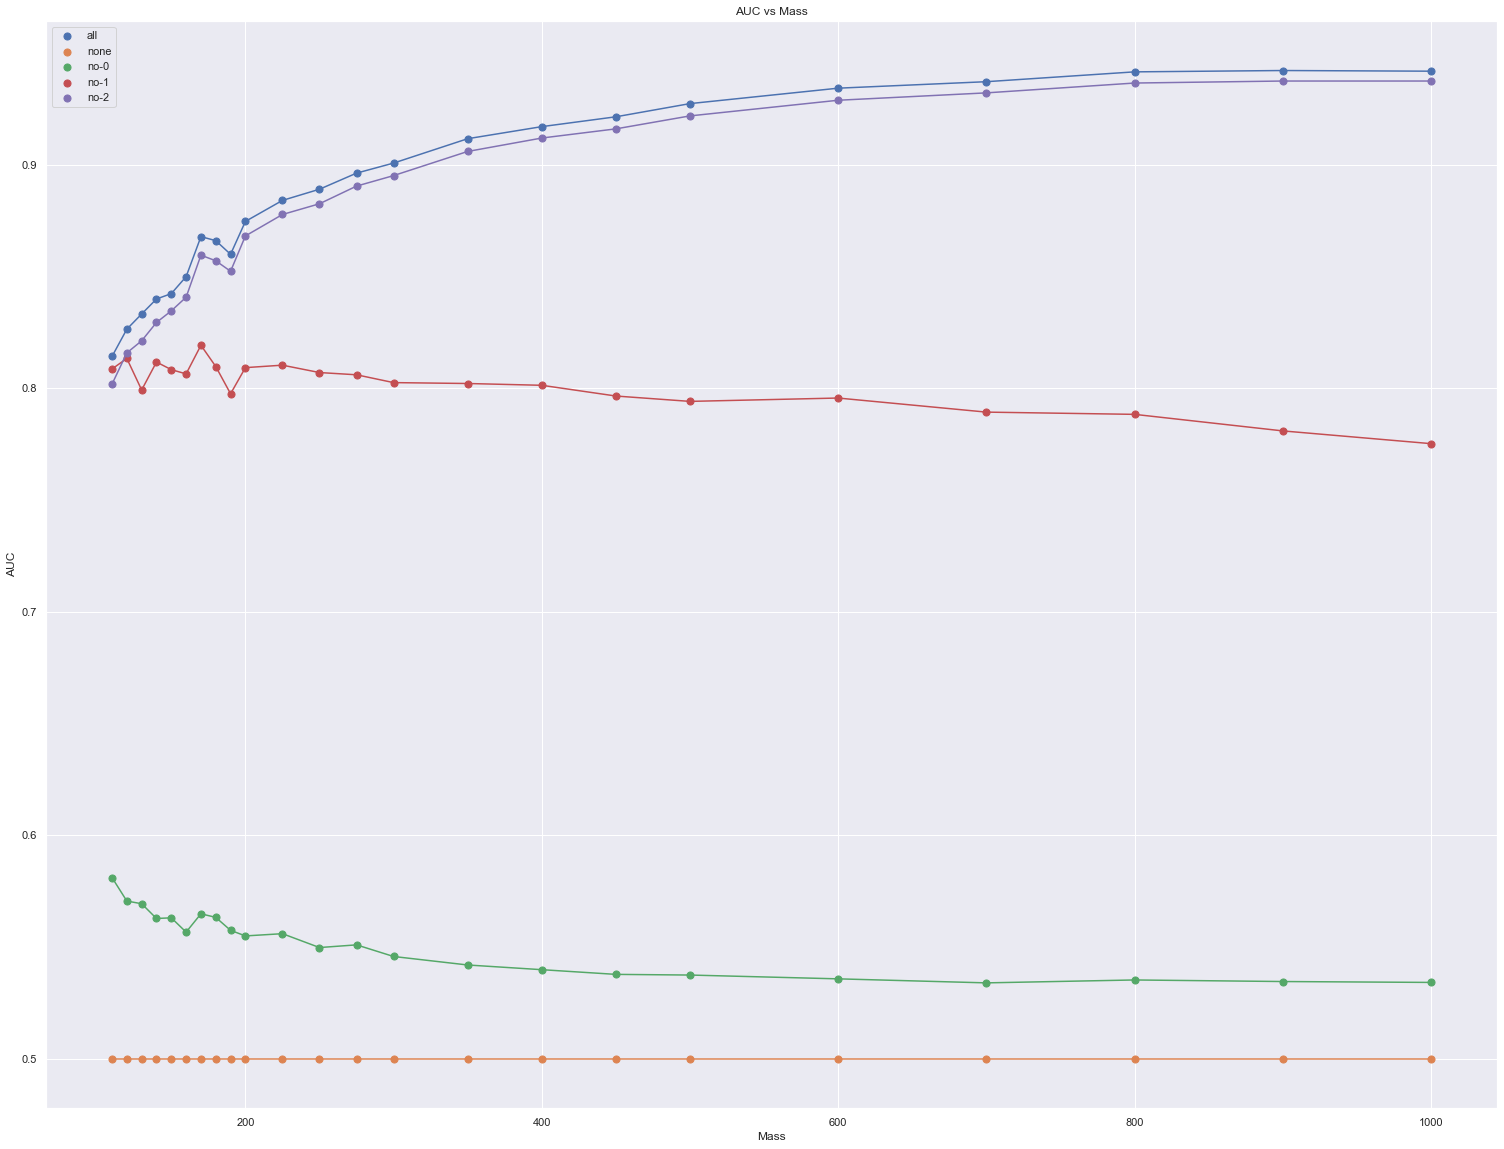

In [12]:
_ = auc_vs_mass_no_features(nn, data, features=features[0], verbose=0, silent=True)

#### PNN

In [13]:
pnn, checkpoint = get_compiled_pnn(save='tom/baseline-pnn')

pnn.fit(x=x_train, y=y_train, batch_size=BATCH_SIZE, validation_split=VAL_SPLIT,
        epochs=NUM_EPOCHS, callbacks=[checkpoint])

# accuracy: 95.26 (+12%), AUC: 99.10 (+8%)

Epoch 1/20
27405/27405 [==============================] - 95s 3ms/step - loss: 0.2556 - binary_accuracy: 0.8411 - auc: 0.9192 - precision_1: 0.7901 - recall_1: 0.8649 - lr: 0.0010 - grad-norm: 1.8005 - weight-norm: 40.8257 - reg-losses: 0.0000e+00 - val_loss: 0.3291 - val_binary_accuracy: 0.8519 - val_auc: 0.9300 - val_precision_1: 0.7907 - val_recall_1: 0.8965
Epoch 2/20
27405/27405 [==============================] - 96s 4ms/step - loss: 0.3294 - binary_accuracy: 0.8548 - auc: 0.9315 - precision_1: 0.8064 - recall_1: 0.8774 - lr: 0.0010 - grad-norm: 2.4118 - weight-norm: 70.8826 - reg-losses: 0.0000e+00 - val_loss: 0.3337 - val_binary_accuracy: 0.8481 - val_auc: 0.9302 - val_precision_1: 0.8308 - val_recall_1: 0.8170
Epoch 3/20
27405/27405 [==============================] - 92s 3ms/step - loss: 0.3689 - binary_accuracy: 0.8609 - auc: 0.9367 - precision_1: 0.8134 - recall_1: 0.8833 - lr: 0.0010 - grad-norm: 2.7885 - weight-norm: 89.7308 - reg-losses: 0.0000e+00 - val_loss: 0.3092 - val

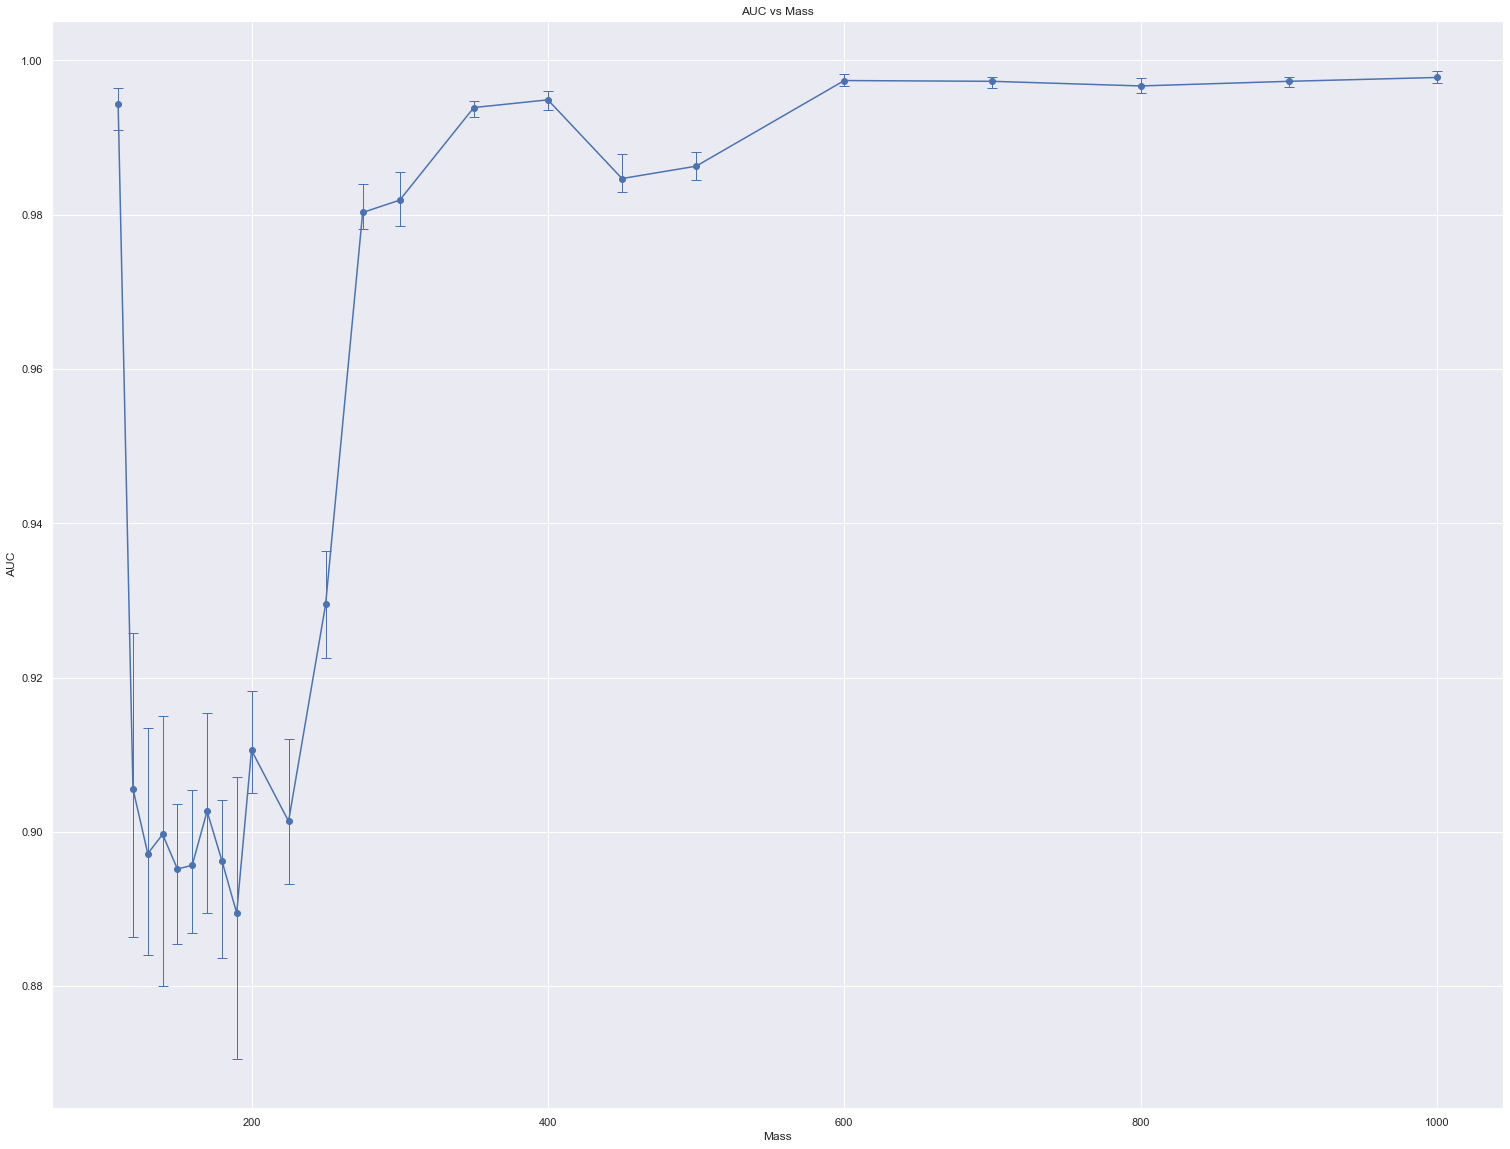

array([0.99425, 0.90565, 0.89725, 0.89967, 0.89518, 0.89572, 0.90271,
       0.89626, 0.8895 , 0.91063, 0.90142, 0.92945, 0.98035, 0.98187,
       0.9939 , 0.99488, 0.9847 , 0.98629, 0.99739, 0.9973 , 0.99672,
       0.9973 , 0.99784])

In [14]:
auc_with_error(pnn, data, silent=True)

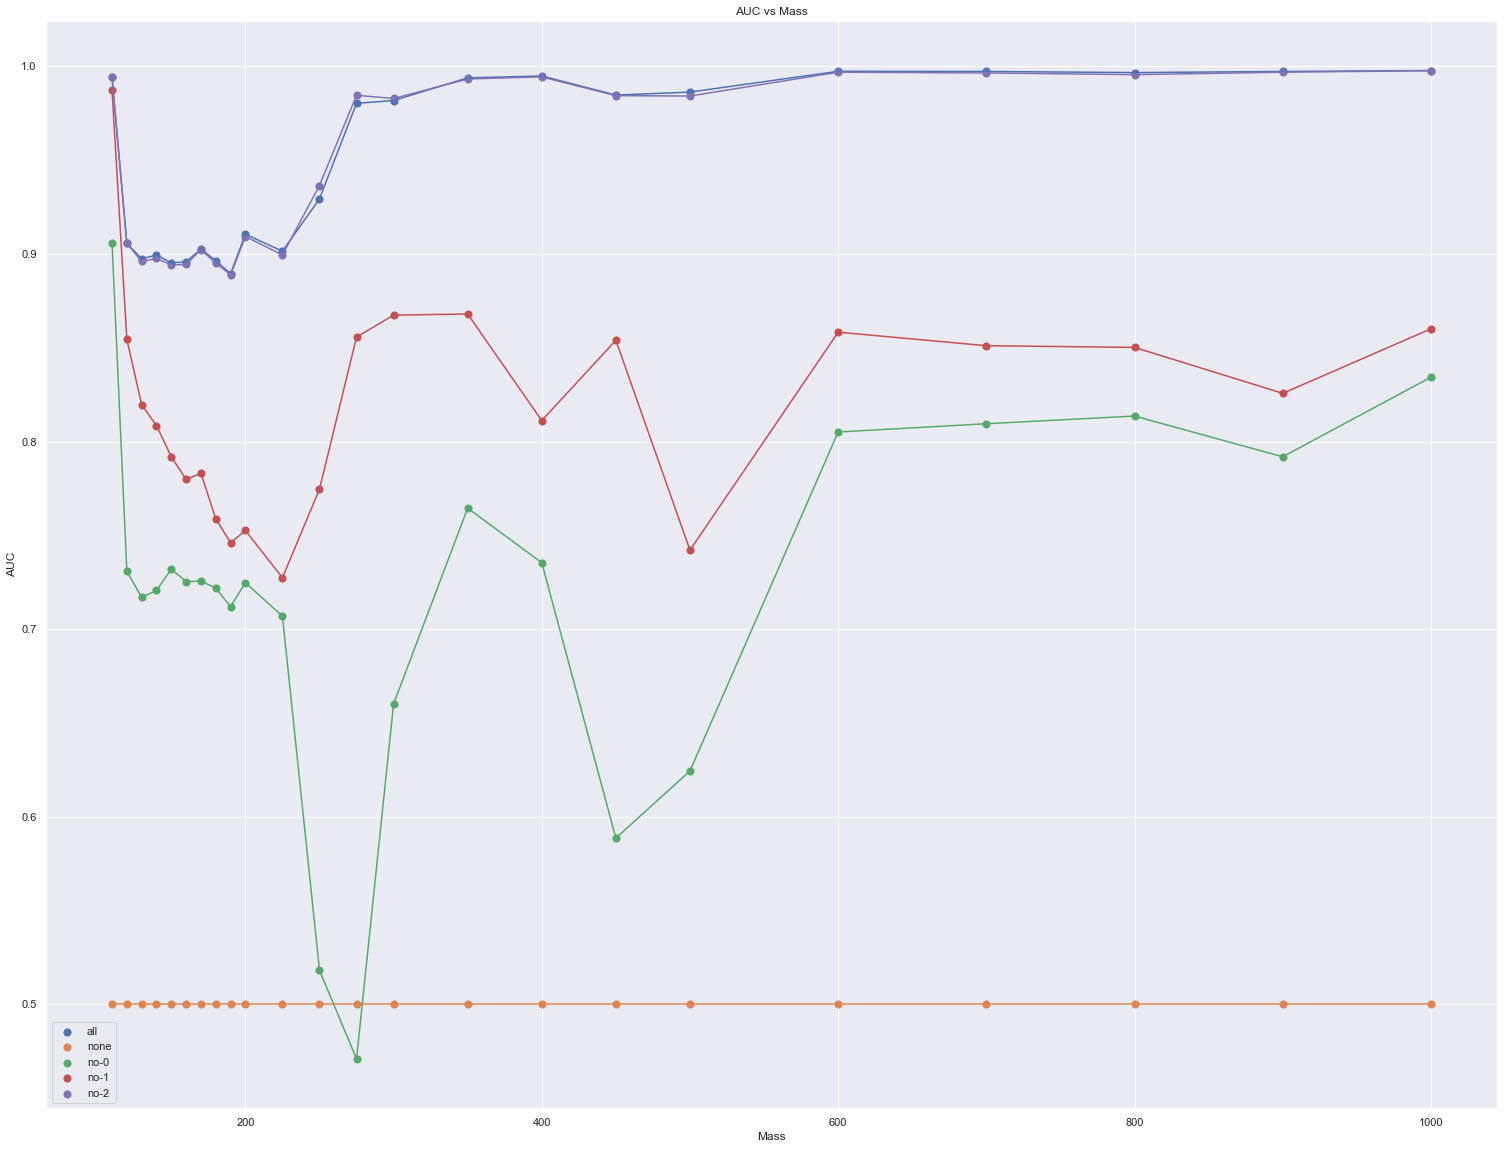

In [15]:
_ = auc_vs_mass_no_features(pnn, data, features=features[0], verbose=0, silent=True)

#### AffinePNN

In [16]:
affine, checkpoint = get_compiled_affine_pnn(save='tom/baseline-affine',
                                            track_mass_reliance=True)

affine.fit(x=x_train, y=y_train, batch_size=BATCH_SIZE, validation_split=VAL_SPLIT,
           epochs=NUM_EPOCHS, callbacks=[checkpoint])

# accuracy: 96.91 (+1.7%), AUC: 99.48 (+0.4%)

Epoch 1/20
27405/27405 [==============================] - 123s 4ms/step - loss: 0.2109 - binary_accuracy: 0.8430 - auc: 0.9222 - precision_2: 0.7983 - recall_2: 0.8559 - cls-loss: 0.3456 - lr: 0.0010 - grad-norm: 3.5552 - weight-norm: 64.7083 - reg-losses: 0.0000e+00 - adversarial-loss: 0.0000e+00 - mass-reliance: 0.1257 - val_loss: 0.2855 - val_binary_accuracy: 0.8758 - val_auc: 0.9466 - val_precision_2: 0.8341 - val_recall_2: 0.8917
Epoch 2/20
27405/27405 [==============================] - 122s 4ms/step - loss: 0.0919 - binary_accuracy: 0.9093 - auc: 0.9695 - precision_2: 0.8720 - recall_2: 0.9280 - cls-loss: 0.2171 - lr: 0.0010 - grad-norm: 12.1408 - weight-norm: 118.9378 - reg-losses: 0.0000e+00 - adversarial-loss: 0.0000e+00 - mass-reliance: 0.4285 - val_loss: 0.1779 - val_binary_accuracy: 0.9293 - val_auc: 0.9791 - val_precision_2: 0.9004 - val_recall_2: 0.9416
Epoch 3/20
27405/27405 [==============================] - 123s 4ms/step - loss: 0.0827 - binary_accuracy: 0.9392 - auc: 

27405/27405 [==============================] - 172s 6ms/step - loss: 0.1091 - binary_accuracy: 0.9644 - auc: 0.9926 - precision_2: 0.9451 - recall_2: 0.9749 - cls-loss: 0.0960 - lr: 0.0010 - grad-norm: 9.2009 - weight-norm: 271.7984 - reg-losses: 0.0000e+00 - adversarial-loss: 0.0000e+00 - mass-reliance: 0.6787 - val_loss: 0.0920 - val_binary_accuracy: 0.9660 - val_auc: 0.9933 - val_precision_2: 0.9450 - val_recall_2: 0.9787
Epoch 20/20
27405/27405 [==============================] - 169s 6ms/step - loss: 0.0419 - binary_accuracy: 0.9648 - auc: 0.9927 - precision_2: 0.9458 - recall_2: 0.9750 - cls-loss: 0.0950 - lr: 0.0010 - grad-norm: 9.2956 - weight-norm: 276.8646 - reg-losses: 0.0000e+00 - adversarial-loss: 0.0000e+00 - mass-reliance: 0.6322 - val_loss: 0.0813 - val_binary_accuracy: 0.9691 - val_auc: 0.9948 - val_precision_2: 0.9513 - val_recall_2: 0.9791


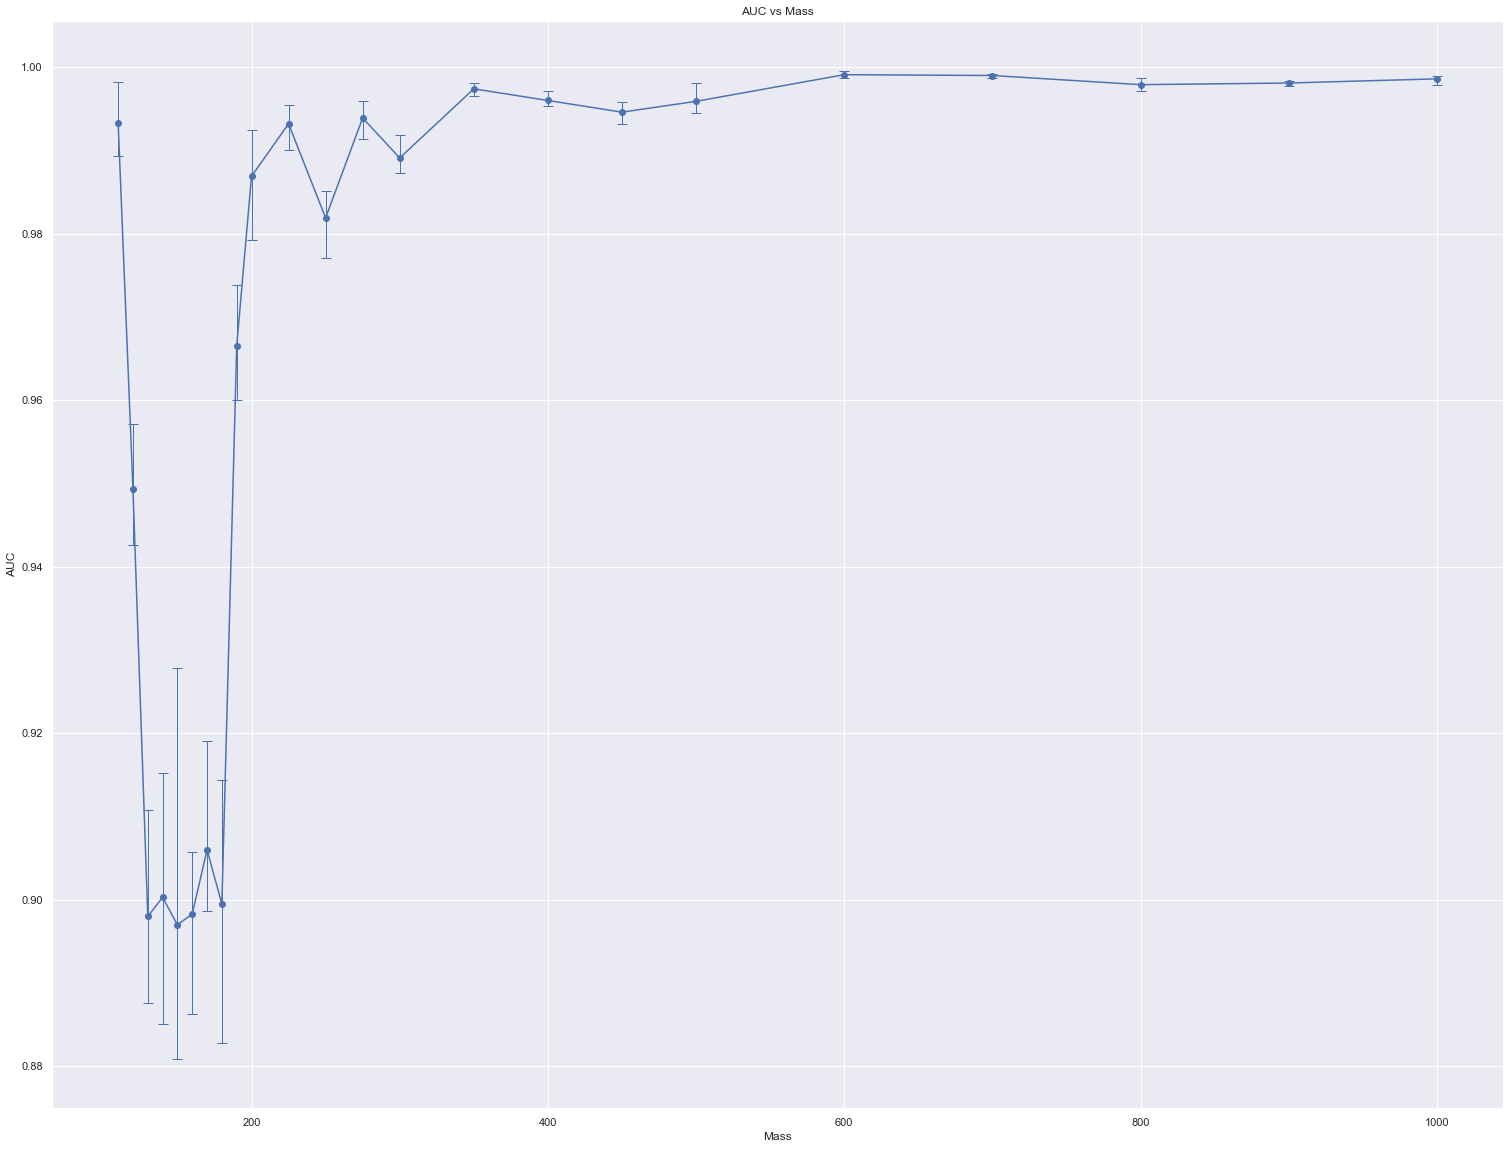

array([0.99331, 0.94934, 0.89795, 0.90034, 0.89705, 0.89826, 0.90605,
       0.89946, 0.96649, 0.98694, 0.99324, 0.9819 , 0.99386, 0.98911,
       0.99743, 0.99605, 0.99463, 0.99586, 0.99907, 0.99898, 0.9979 ,
       0.99807, 0.99864])

In [17]:
auc_with_error(affine, data, silent=True)

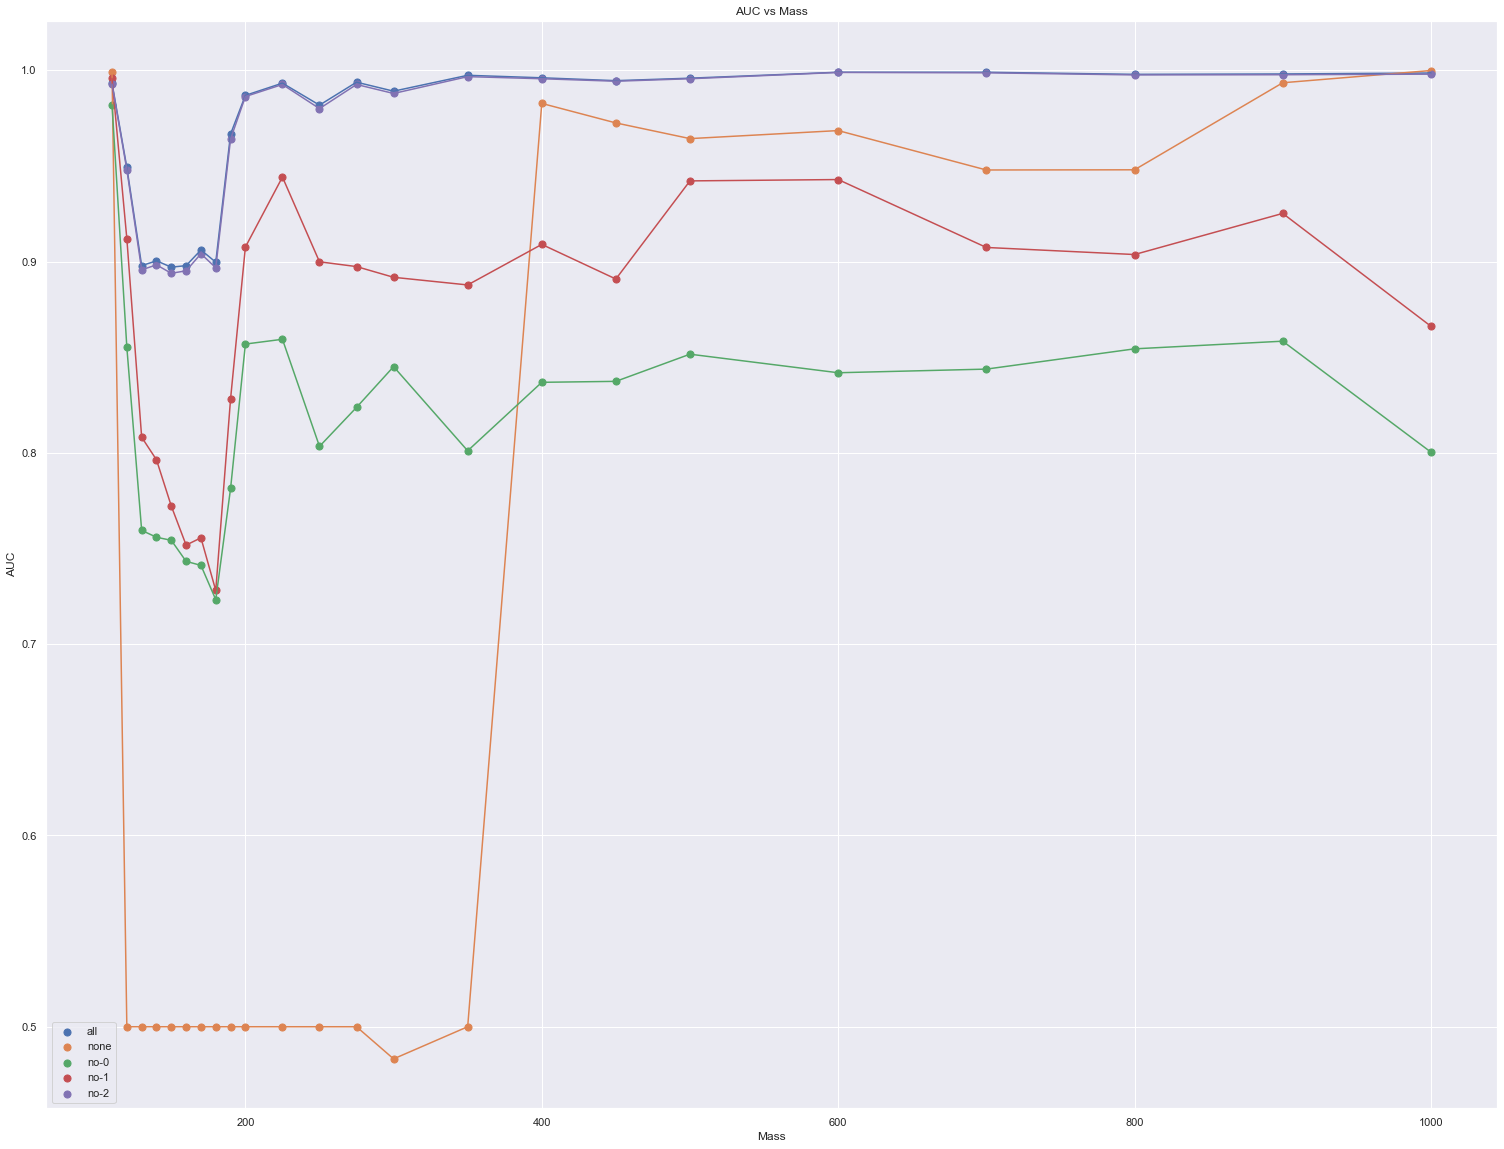

In [18]:
_ = auc_vs_mass_no_features(affine, data, features=features[0], verbose=0, silent=True)

---
AUC comparison:

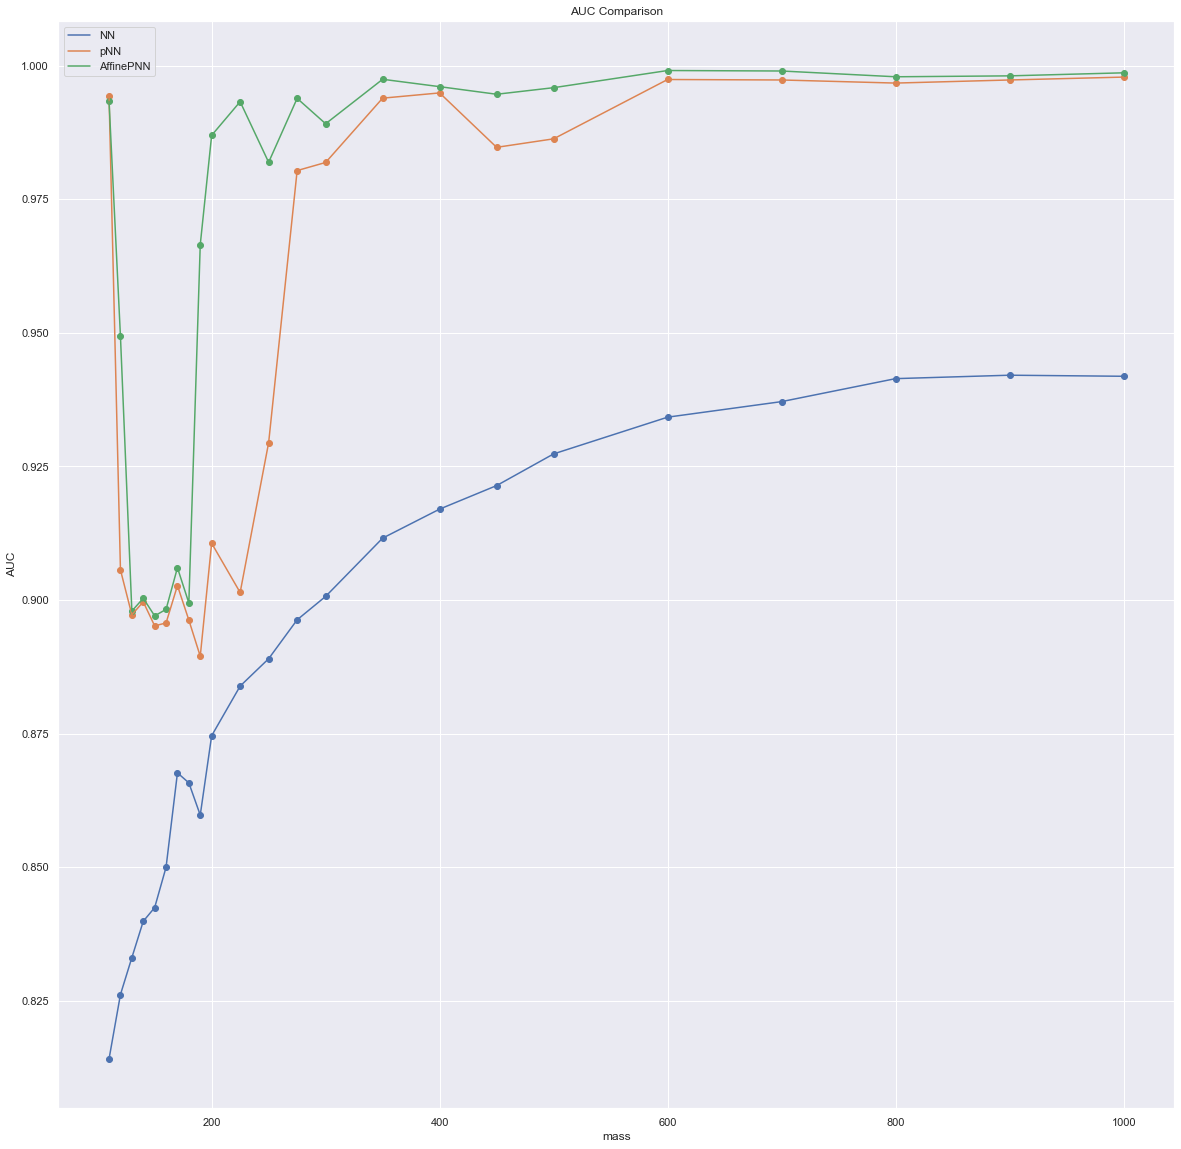

In [19]:
compare_plot(mass=data.unique_signal_mass,
             NN=[0.81417, 0.82621, 0.83311, 0.83991, 0.84247, 0.85001, 0.86768,
                 0.86581, 0.85978, 0.87462, 0.88391, 0.88903, 0.89631, 0.90069,
                 0.91159, 0.91702, 0.92142, 0.92735, 0.93422, 0.93713, 0.94143,
                 0.94207, 0.94187],
             pNN=[0.99425, 0.90565, 0.89725, 0.89967, 0.89518, 0.89572, 0.90271,
                  0.89626, 0.8895 , 0.91063, 0.90142, 0.92945, 0.98035, 0.98187,
                  0.9939 , 0.99488, 0.9847 , 0.98629, 0.99739, 0.9973 , 0.99672,
                  0.9973 , 0.99784],
             AffinePNN=[0.99331, 0.94934, 0.89795, 0.90034, 0.89705, 0.89826, 0.90605,
                        0.89946, 0.96649, 0.98694, 0.99324, 0.9819 , 0.99386, 0.98911,
                        0.99743, 0.99605, 0.99463, 0.99586, 0.99907, 0.99898, 0.9979 ,
                        0.99807, 0.99864])

### Robust
Clipped outliers.

In [9]:
data = Dataset(x_scaler=MinMaxScaler(), m_scaler=MinMaxScaler())
data.load(robust=True)

free_mem()
x_train, y_train = data.get()

[signal] loading...
[background] loading...
[Dataset] clipping outliers..
[Dataset] fitting feature scaler..
[Dataset] fitting mass scaler..
[Dataset] loaded.


In [10]:
num_features = len(data.columns['feature'])
features = []

j = -1
for i in range(num_features):
    # add an entry telling to drop only the i-th feature column
    if i % 3 == 0:
        features.append({'all': [], 'none': np.arange(0, num_features)})
        j += 1

    features[j][f'no-{i}'] = [i]

#### Non-parametric NN

In [11]:
nn, checkpoint = get_compiled_non_parametric(save='tom/baseline-nn-robust')

nn.fit(x=x_train, y=y_train, batch_size=128, validation_split=VAL_SPLIT, 
       epochs=NUM_EPOCHS, callbacks=[checkpoint])

# Accuracy: 83.68, AUC: 91.75

Epoch 1/20
21410/21410 [==============================] - 99s 5ms/step - loss: 0.4222 - binary_accuracy: 0.8201 - auc: 0.9005 - precision: 0.7720 - recall: 0.8333 - lr: 0.0010 - grad-norm: 1.4313 - weight-norm: 33.5675 - reg-losses: 0.0000e+00 - val_loss: 0.3763 - val_binary_accuracy: 0.8289 - val_auc: 0.9096 - val_precision: 0.7939 - val_recall: 0.8189
Epoch 2/20
21410/21410 [==============================] - 97s 5ms/step - loss: 0.2915 - binary_accuracy: 0.8292 - auc: 0.9093 - precision: 0.7825 - recall: 0.8421 - lr: 0.0010 - grad-norm: 1.2881 - weight-norm: 55.3006 - reg-losses: 0.0000e+00 - val_loss: 0.3681 - val_binary_accuracy: 0.8311 - val_auc: 0.9120 - val_precision: 0.7879 - val_recall: 0.8368
Epoch 3/20
21410/21410 [==============================] - 99s 5ms/step - loss: 0.3751 - binary_accuracy: 0.8320 - auc: 0.9121 - precision: 0.7849 - recall: 0.8462 - lr: 0.0010 - grad-norm: 1.1885 - weight-norm: 70.1566 - reg-losses: 0.0000e+00 - val_loss: 0.3647 - val_binary_accuracy: 0.

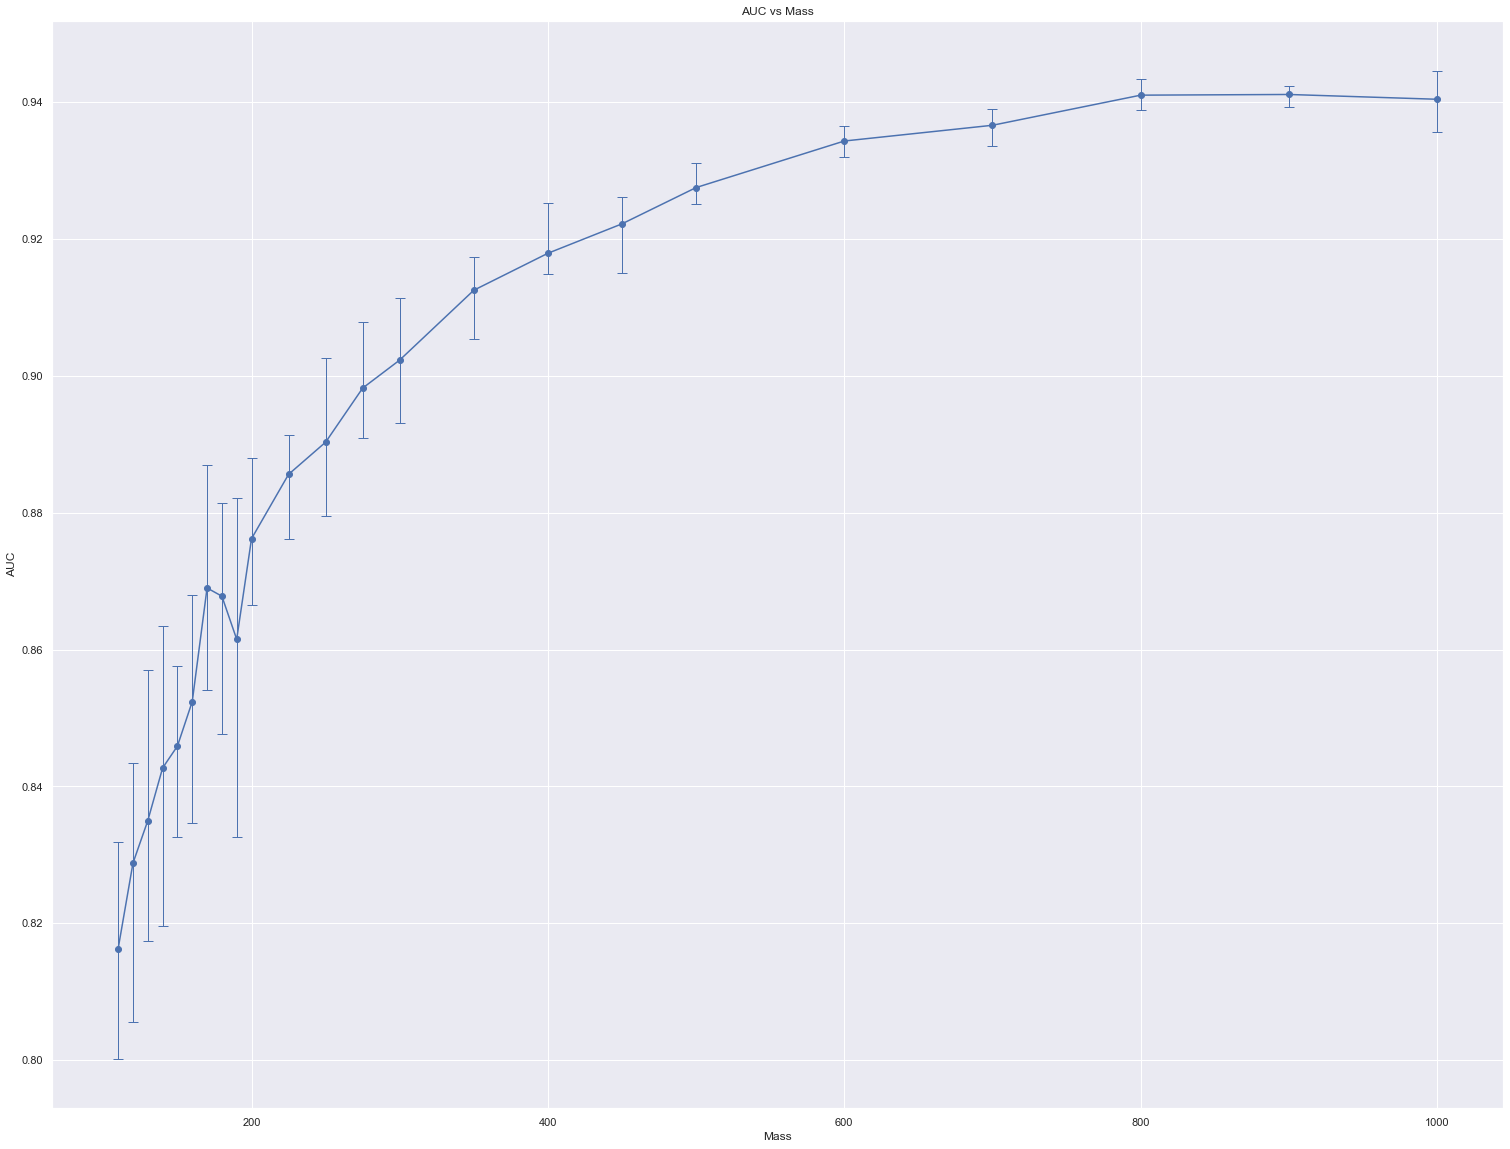

array([0.8163 , 0.82878, 0.83499, 0.84269, 0.84592, 0.85245, 0.86904,
       0.86779, 0.86149, 0.87623, 0.88562, 0.89028, 0.89824, 0.90231,
       0.91254, 0.91794, 0.92223, 0.92747, 0.93427, 0.93658, 0.94101,
       0.94107, 0.94036])

In [12]:
auc_with_error(nn, data, silent=True)

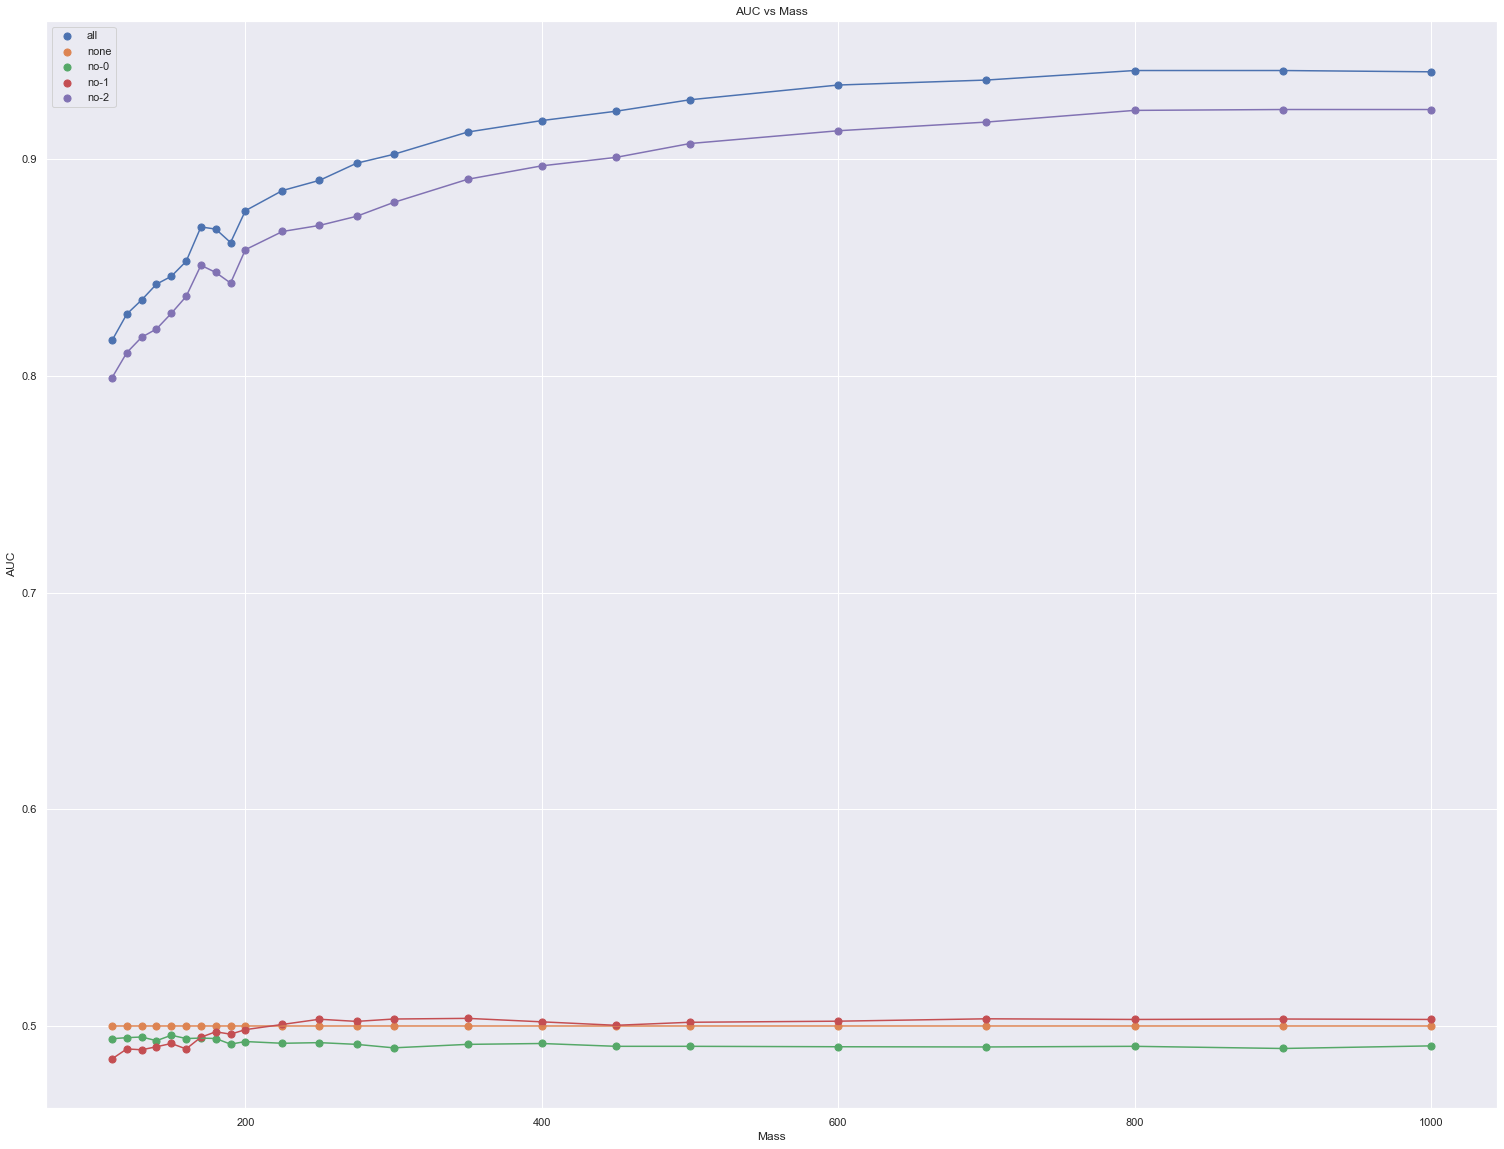

In [13]:
_ = auc_vs_mass_no_features(nn, data, features=features[0], verbose=0, silent=True)

#### PNN

In [7]:
pnn, checkpoint = get_compiled_pnn(save='tom/baseline-pnn-robust')
pnn.summary()

Model: "ParametricNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
m (InputLayer)                  [(None, 1)]          0                                            
__________________________________________________________________________________________________
x (InputLayer)                  [(None, 13)]         0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 14)           0           m[0][0]                          
                                                                 x[0][0]                          
__________________________________________________________________________________________________
dense (Dense)                   (None, 300)          4500        concatenate[0][0]     

In [8]:
h = pnn.fit(x=x_train, y=y_train, batch_size=128, validation_split=VAL_SPLIT, 
            epochs=NUM_EPOCHS, callbacks=[checkpoint])

# Accuracy: 95.85, AUC: 99.26

Epoch 1/20
21410/21410 [==============================] - 79s 4ms/step - loss: 0.3136 - binary_accuracy: 0.8402 - auc: 0.9186 - precision: 0.7896 - recal: 0.8632 - lr: 0.0010 - grad-norm: 1.9225 - weight-norm: 37.9460 - reg-losses: 0.0000e+00 - val_loss: 0.3383 - val_binary_accuracy: 0.8432 - val_auc: 0.9256 - val_precision: 0.8150 - val_recal: 0.8271
Epoch 2/20
21410/21410 [==============================] - 76s 4ms/step - loss: 0.2426 - binary_accuracy: 0.8558 - auc: 0.9324 - precision: 0.8077 - recal: 0.8780 - lr: 0.0010 - grad-norm: 2.4675 - weight-norm: 63.9784 - reg-losses: 0.0000e+00 - val_loss: 0.3091 - val_binary_accuracy: 0.8601 - val_auc: 0.9378 - val_precision: 0.8161 - val_recal: 0.8755
Epoch 3/20
21410/21410 [==============================] - 77s 4ms/step - loss: 0.3135 - binary_accuracy: 0.8624 - auc: 0.9381 - precision: 0.8158 - recal: 0.8837 - lr: 0.0010 - grad-norm: 2.7432 - weight-norm: 80.2816 - reg-losses: 0.0000e+00 - val_loss: 0.3029 - val_binary_accuracy: 0.8660 

In [8]:
pnn.load_weights('weights/tom/baseline-pnn-robust/weights-17-0.993')

* With outliers clipping a PNN can gather **+2% in AUC**, thus matching an AffinePNN without its downsides.
* Accuracy is still 2% lower.

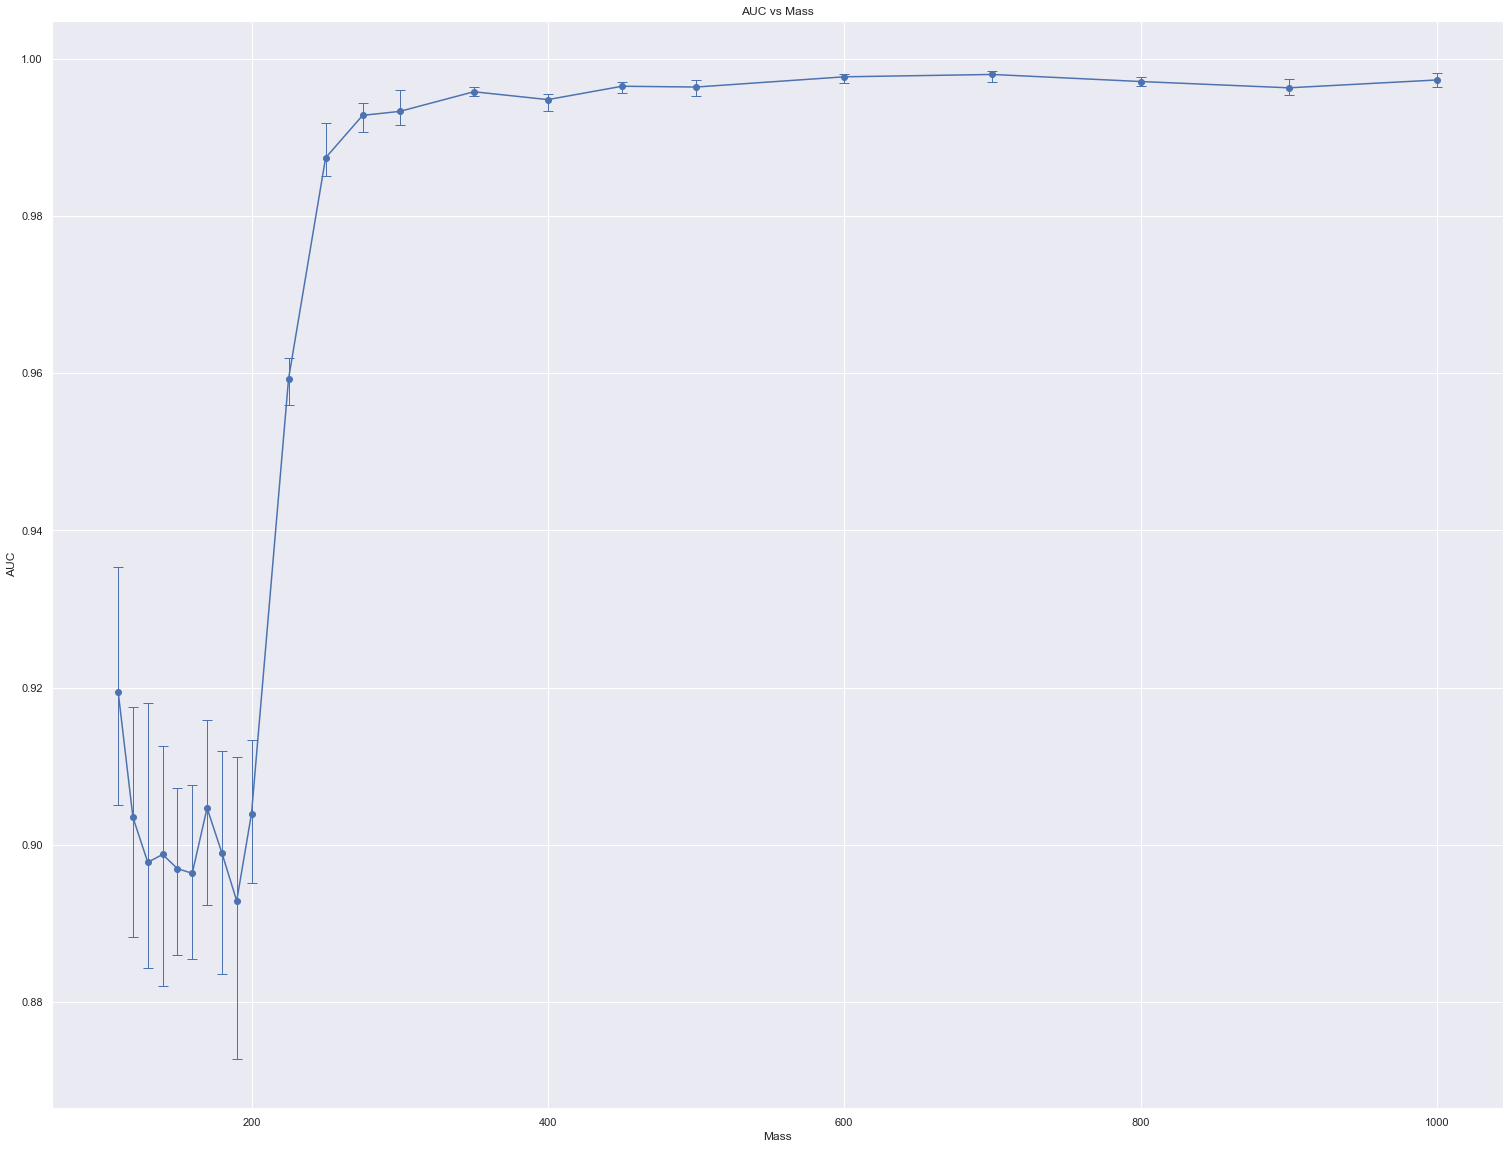

array([0.91952, 0.90347, 0.89782, 0.89876, 0.89698, 0.89635, 0.90466,
       0.89897, 0.89288, 0.90401, 0.95928, 0.98745, 0.99283, 0.99327,
       0.99576, 0.99475, 0.99652, 0.99641, 0.99768, 0.99799, 0.99709,
       0.99627, 0.99728])

In [9]:
auc_with_error(pnn, data, silent=True)

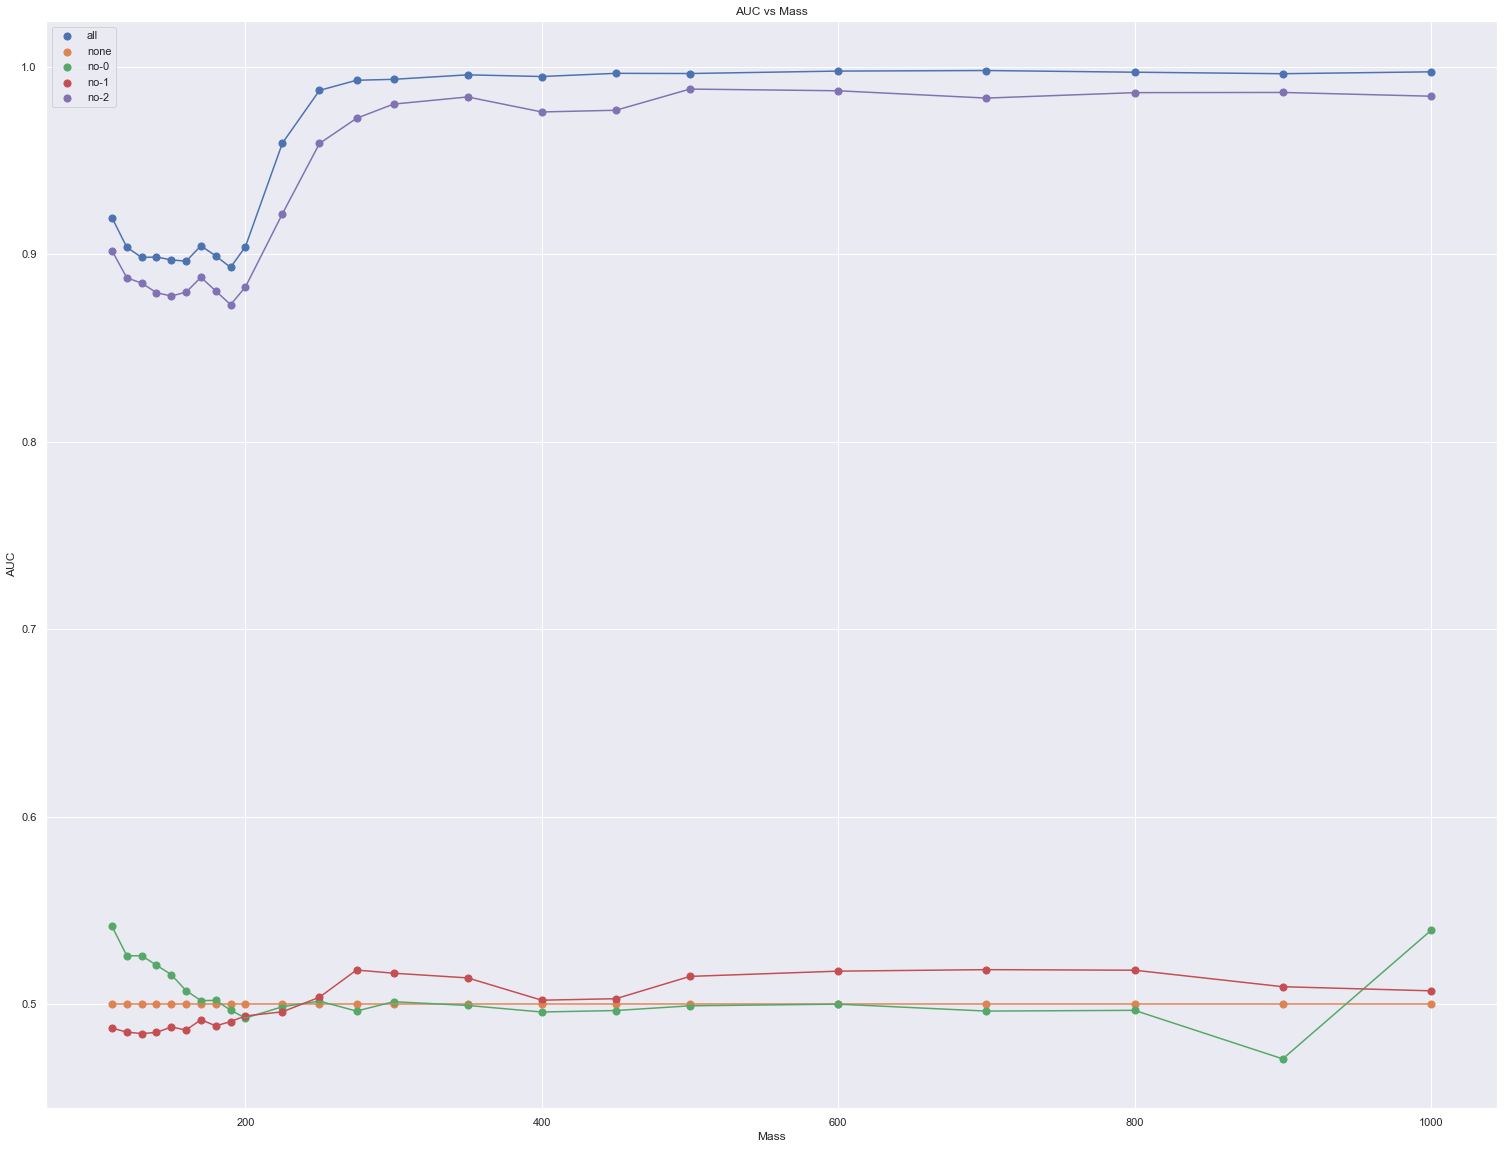

In [10]:
_ = auc_vs_mass_no_features(pnn, data, features=features[0], verbose=0, silent=True)

#### AffinePNN

In [11]:
affine, checkpoint = get_compiled_affine_pnn(save='tom/baseline-affine-robust',
                                             track_mass_reliance=True)
affine.summary()

Model: "ParametricNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x (InputLayer)                  [(None, 13)]         0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 300)          4200        x[0][0]                          
__________________________________________________________________________________________________
m (InputLayer)                  [(None, 1)]          0                                            
__________________________________________________________________________________________________
affine-0 (AffineConditioning)   (None, 300)          1200        dense_4[0][0]                    
                                                                 m[0][0]               

In [9]:
h = affine.fit(x=x_train, y=y_train, batch_size=128, validation_split=VAL_SPLIT, 
               epochs=NUM_EPOCHS, callbacks=[checkpoint])

# Accuracy: 97.37, AUC: 99.51

Epoch 1/20
21410/21410 [==============================] - 95s 4ms/step - loss: 0.3248 - binary_accuracy: 0.8352 - auc: 0.9152 - precision: 0.7902 - recal: 0.8464 - cls-loss: 0.3604 - lr: 0.0010 - grad-norm: 1.2132 - weight-norm: 59.1565 - reg-losses: 0.0000e+00 - adversarial-loss: 0.0000e+00 - val_loss: 0.3374 - val_binary_accuracy: 0.8428 - val_auc: 0.9271 - val_precision: 0.8224 - val_recal: 0.8142
Epoch 2/20
21410/21410 [==============================] - 94s 4ms/step - loss: 0.1237 - binary_accuracy: 0.8855 - auc: 0.9546 - precision: 0.8440 - recal: 0.9044 - cls-loss: 0.2653 - lr: 0.0010 - grad-norm: 8.2854 - weight-norm: 113.9863 - reg-losses: 0.0000e+00 - adversarial-loss: 0.0000e+00 - val_loss: 0.1761 - val_binary_accuracy: 0.9269 - val_auc: 0.9802 - val_precision: 0.8936 - val_recal: 0.9443
Epoch 3/20
21410/21410 [==============================] - 92s 4ms/step - loss: 0.1375 - binary_accuracy: 0.9318 - auc: 0.9806 - precision: 0.9027 - recal: 0.9453 - cls-loss: 0.1699 - lr: 0.00

In [12]:
affine.load_weights('weights/tom/baseline-affine-robust/weights-20-0.995')

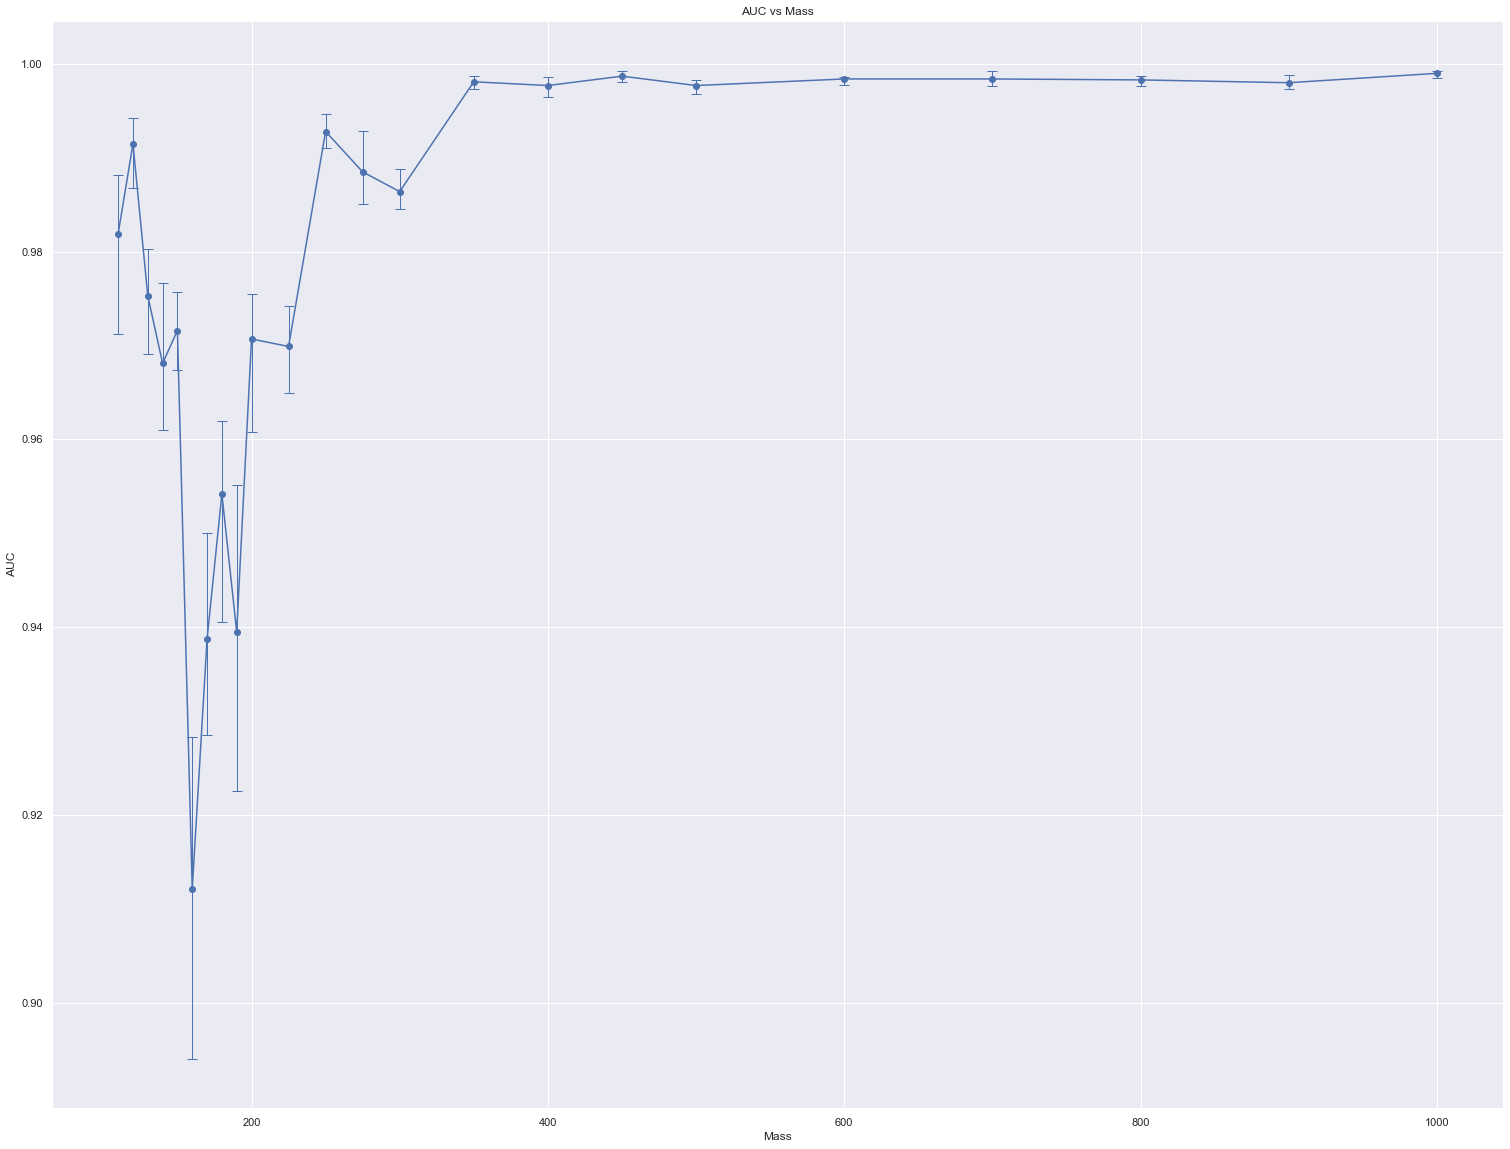

array([0.98188, 0.99154, 0.97528, 0.96811, 0.97155, 0.91214, 0.93866,
       0.95424, 0.93947, 0.97069, 0.96987, 0.99282, 0.98854, 0.98642,
       0.99809, 0.99774, 0.99872, 0.99768, 0.99836, 0.9984 , 0.99829,
       0.99801, 0.99895])

In [13]:
auc_with_error(affine, data, verbose=0, silent=True)

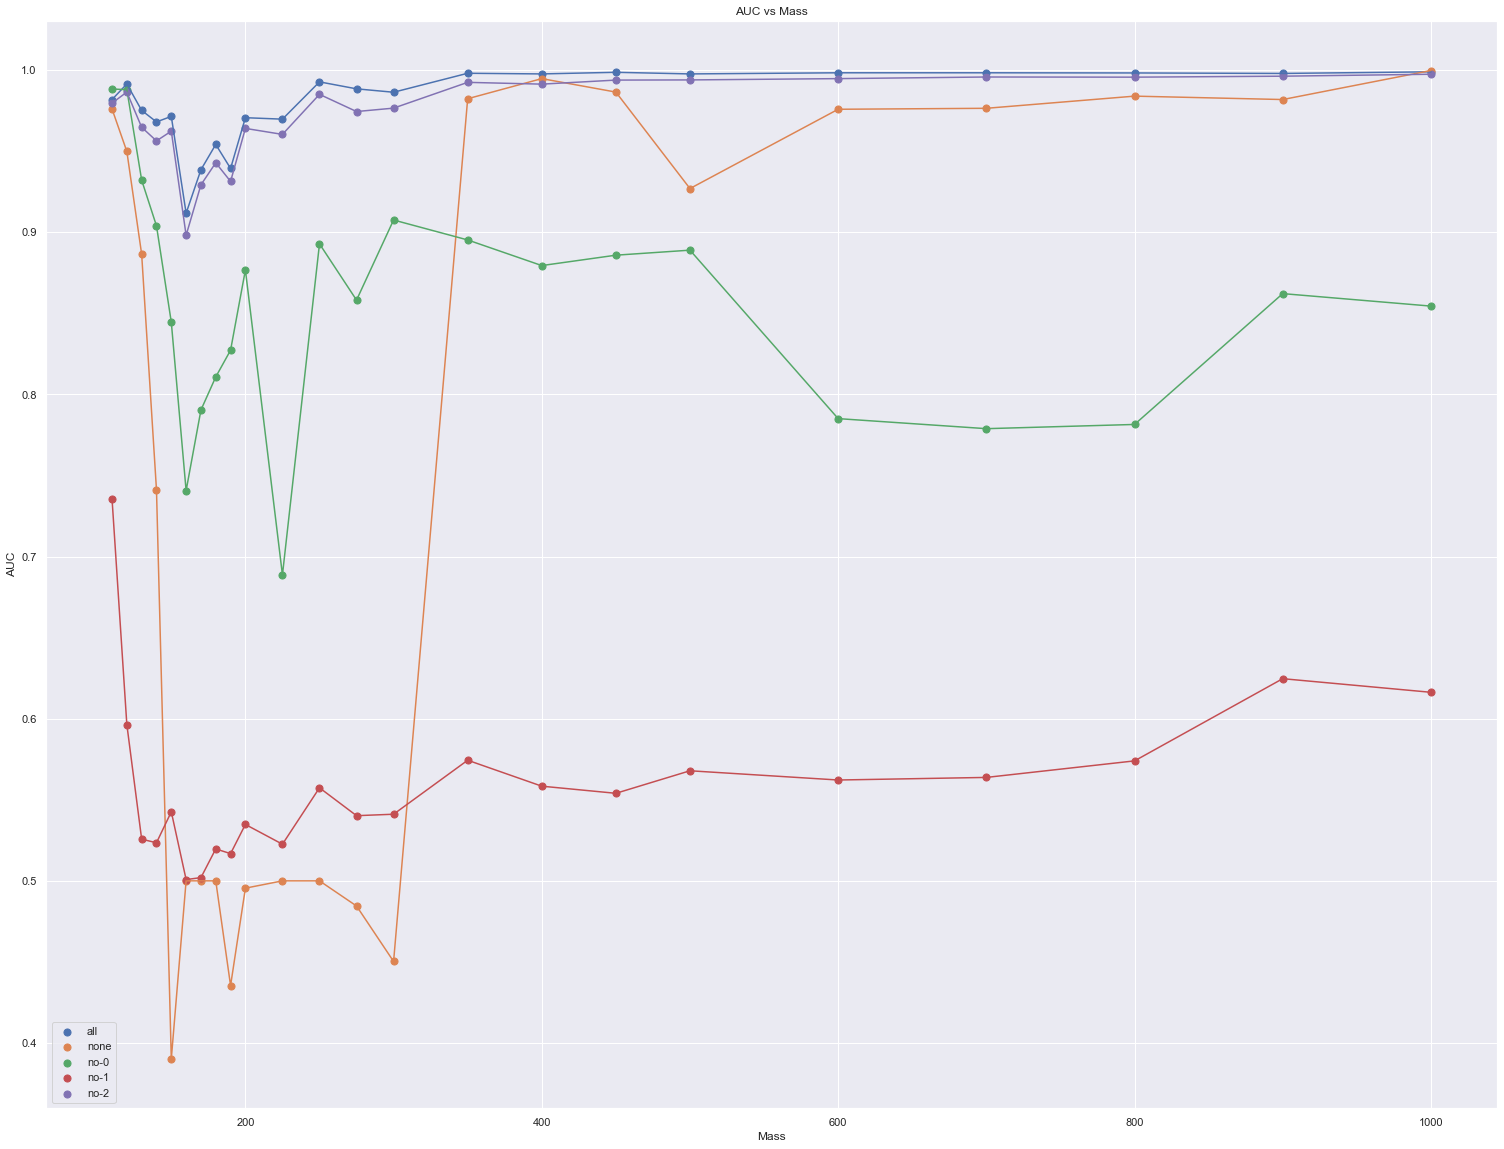

In [13]:
_ = auc_vs_mass_no_features(affine, data, features=features[0], verbose=0, silent=True)

---
AUC comparison: NN vs PNN vs AffinePNN

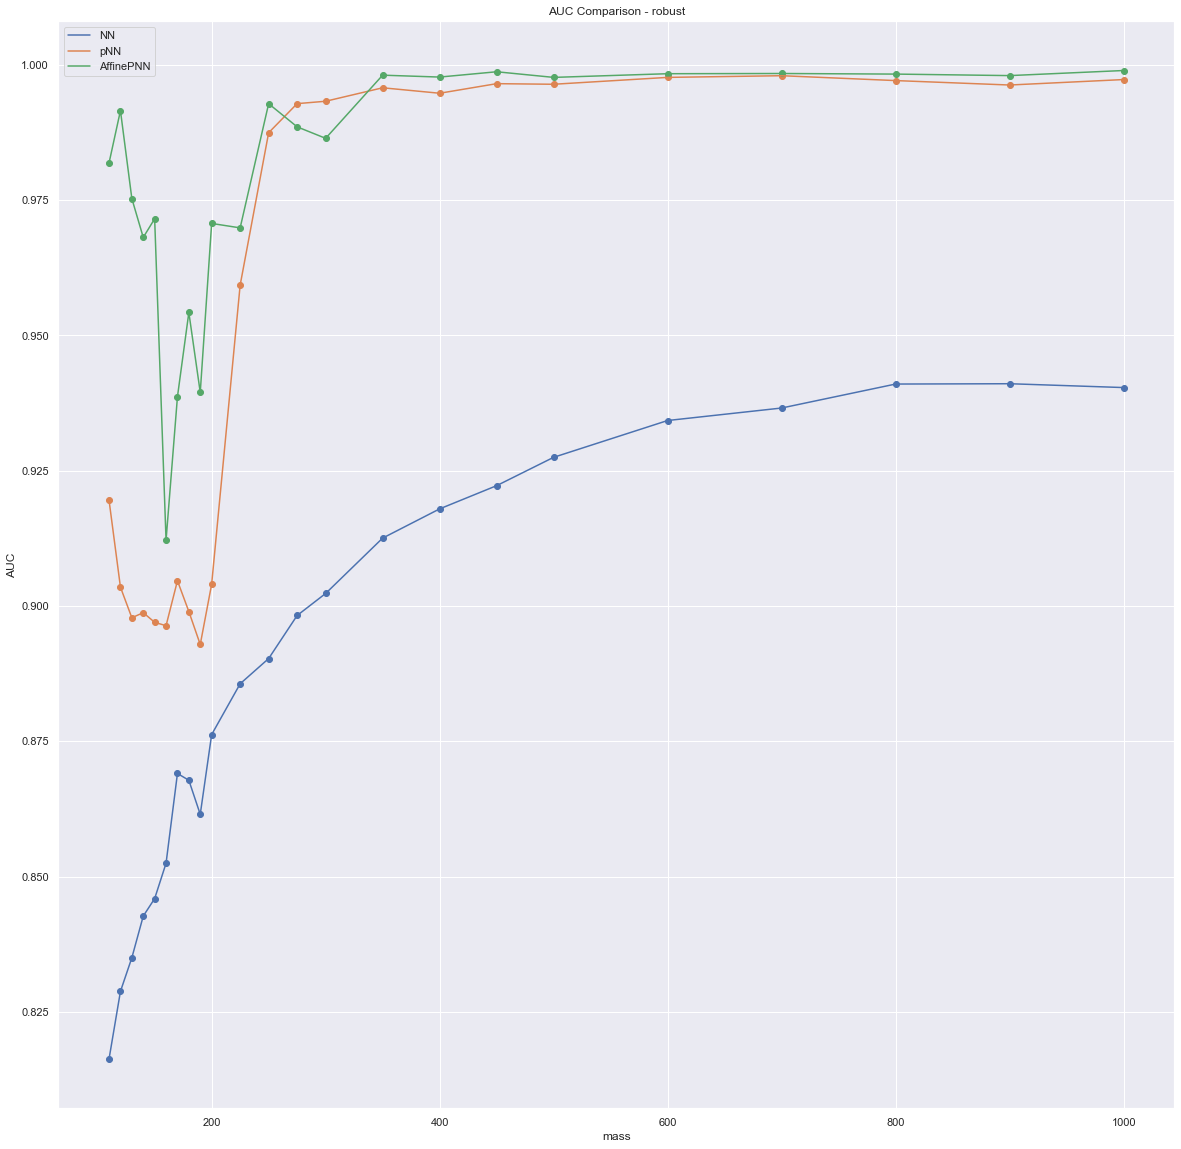

In [14]:
compare_plot(mass=data.unique_signal_mass,
             title='AUC Comparison - robust',
             NN=[0.8163 , 0.82878, 0.83499, 0.84269, 0.84592, 0.85245, 0.86904,
                 0.86779, 0.86149, 0.87623, 0.88562, 0.89028, 0.89824, 0.90231,
                 0.91254, 0.91794, 0.92223, 0.92747, 0.93427, 0.93658, 0.94101,
                 0.94107, 0.94036],
             pNN=[0.91952, 0.90347, 0.89782, 0.89876, 0.89698, 0.89635, 0.90466,
                  0.89897, 0.89288, 0.90401, 0.95928, 0.98745, 0.99283, 0.99327,
                  0.99576, 0.99475, 0.99652, 0.99641, 0.99768, 0.99799, 0.99709,
                  0.99627, 0.99728],
             AffinePNN=[0.98188, 0.99154, 0.97528, 0.96811, 0.97155, 0.91214, 0.93866,
                        0.95424, 0.93947, 0.97069, 0.96987, 0.99282, 0.98854, 0.98642,
                        0.99809, 0.99774, 0.99872, 0.99768, 0.99836, 0.9984 , 0.99829,
                        0.99801, 0.99895])